In [39]:
import os
import shutil
import warnings
from itertools import combinations

import numpy as np
import pandas as pd
import yaml
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.signal import savgol_filter, medfilt
import starbars

from towbintools.foundation import file_handling
from towbintools.foundation.utils import interpolate_nans
from towbintools.data_analysis import (
    compute_larval_stage_duration,
    compute_series_at_time_classified,
    filter_series_with_classification,
    rescale_and_aggregate,
    rescale_series,
)
from plotting_functions import (
    combine_experiments,
    plot_aggregated_series,
    plot_correlation,
    plot_correlation_at_ecdysis,
    boxplot_at_molt,
    plot_growth_curves_individuals,
    plot_deviation_from_model_at_ecdysis,
    plot_normalized_proportions,
    plot_deviation_from_model,
    get_most_average_deviations_at_ecdysis,
    get_most_average_proportions_at_ecdysis,
    get_most_average_size_at_ecdysis,
    plot_developmental_success,
    plot_arrests,
    plot_heterogeneity_at_ecdysis,
    plot_heterogeneity_rescaled_data,
    build_legend,
    combine_series,
    transform_series,
    compute_growth_rate,
    rescale,
)

# Configure warnings
warnings.filterwarnings("once")

In [40]:
filemap_paths = [
    "/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis_sacha/report/analysis_filemap_annotated.csv",
    "/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/report/analysis_filemap_annotated.csv",
]

conditions_paths = [
    "/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/doc/conditions.yaml",
    "/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/doc/conditions.yaml",
]

organ_channels = [{'body': 2, 'pharynx' : 1}]

backup_path = "/mnt/towbin.data/shared/spsalmon/plotting_backups/yap1_deletion/"

filemap_backup_path = os.path.join(backup_path, "filemaps")
conditions_backup_path = os.path.join(backup_path, "conditions")
structure_backup_path = os.path.join(backup_path, "structure")

os.makedirs(backup_path, exist_ok=True)
os.makedirs(filemap_backup_path, exist_ok=True)
os.makedirs(conditions_backup_path, exist_ok=True)
os.makedirs(structure_backup_path, exist_ok=True)

for i, (filemap_path, config_path) in enumerate(zip(filemap_paths, conditions_paths)):
    output_name = f"analysis_filemap_{i}.csv"
    output_name_config = f"config_{i}.yaml"
    
    # Copy the filemap to the backup path
    shutil.copy(filemap_path, os.path.join(filemap_backup_path, output_name))
    shutil.copy(config_path, os.path.join(conditions_backup_path, output_name_config))

# Copy the current working directory to the backup path
current_dir = os.getcwd()
current_dir_name = os.path.basename(current_dir)
destination = os.path.join(backup_path, current_dir_name)

shutil.copytree(current_dir, destination, dirs_exist_ok=True)

print("Backup completed successfully!")

Backup completed successfully!


In [41]:
import pickle
conditions_struct = combine_experiments(filemap_paths, conditions_paths, organ_channels=organ_channels, recompute_values_at_molt=False)

# backup the conditions struct
with open(os.path.join(structure_backup_path, "plotting_struct.pkl"), "wb") as f:
    pickle.dump(conditions_struct, f)

Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returni

In [42]:
for condition in conditions_struct:
    print(f"Condition: {condition['condition_id'], {condition['description']}}, Number of individuals: {condition['ecdysis_time_step'].shape[0]}")

Condition: (0, {'WT yap-1, no TIR'}), Number of individuals: 58
Condition: (1, {'WT yap-1, col-10:TIR'}), Number of individuals: 55
Condition: (2, {'yap-1 (tm1416), no TIR'}), Number of individuals: 79
Condition: (3, {'yap-1 (tm1416), col-10:TIR'}), Number of individuals: 76
Condition: (4, {'yap-1 (abt7), no TIR'}), Number of individuals: 99
Condition: (5, {'yap-1 (abt7), col-10:TIR'}), Number of individuals: 155


In [43]:
# change figure size to your liking
plt.rcParams['figure.figsize'] = [12, 10]

# make lines thicker
plt.rcParams['lines.linewidth'] = 2

# make font size bigger
plt.rcParams.update({'font.size': 12})

In [44]:
conditions_struct = combine_series(conditions_struct, 'body_seg_str_width_mean_at_ecdysis', 'body_seg_str_length_at_ecdysis', 'divide', 'body_seg_str_aspect_ratio_at_ecdysis')
conditions_struct = combine_series(conditions_struct, 'body_seg_str_width_mean', 'body_seg_str_length', 'divide', 'body_seg_str_aspect_ratio')
conditions_struct = combine_series(conditions_struct, 'body_seg_str_width_max_at_ecdysis', 'body_seg_str_width_mean_at_ecdysis', 'subtract', 'body_seg_str_width_max_minus_mean_at_ecdysis')

conditions_struct = combine_series(conditions_struct, 'pharynx_seg_str_width_mean_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', 'divide', 'pharynx_seg_str_aspect_ratio_at_ecdysis')
conditions_struct = combine_series(conditions_struct, 'pharynx_seg_str_width_mean', 'pharynx_seg_str_length', 'divide', 'pharynx_seg_str_aspect_ratio')

conditions_struct = transform_series(conditions_struct, 'body_seg_str_width_mean', 'log', 'body_seg_str_log_width_mean')
conditions_struct = transform_series(conditions_struct, 'body_seg_str_length', 'log', 'body_seg_str_log_length')
conditions_struct = transform_series(conditions_struct, 'body_seg_str_volume', 'log', 'body_seg_str_log_volume')

In [45]:

# COMPUTE GROWTH RATES
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_volume', 'body_seg_str_volume_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_width_mean', 'body_seg_str_width_mean_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_length', 'body_seg_str_length_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_aspect_ratio', 'body_seg_str_aspect_ratio_growth_rate')

# COMPUTE GROWTH RATES FOR LOG TRANSFORMED SERIES
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_log_width_mean', 'body_seg_str_log_width_mean_growth_rate', experiment_time=False)
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_log_length', 'body_seg_str_log_length_growth_rate', experiment_time=False)
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_log_volume', 'body_seg_str_log_volume_growth_rate', experiment_time=False)

# RESCALE GROWTH RATES
conditions_struct = rescale(conditions_struct, 'body_seg_str_volume_growth_rate', 'body_seg_str_volume_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_width_mean_growth_rate', 'body_seg_str_width_mean_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_length_growth_rate', 'body_seg_str_length_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_aspect_ratio_growth_rate', 'body_seg_str_aspect_ratio_growth_rate_rescaled')

# RESCALE GROWTH RATES FOR LOG TRANSFORMED SERIES
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_width_mean_growth_rate', 'body_seg_str_log_width_mean_growth_rate_rescaled', experiment_time=False)
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_length_growth_rate', 'body_seg_str_log_length_growth_rate_rescaled', experiment_time=False)
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_volume_growth_rate', 'body_seg_str_log_volume_growth_rate_rescaled', experiment_time=False)

# RESCALE SERIES
conditions_struct = rescale(conditions_struct, 'body_seg_str_volume', 'body_seg_str_volume_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_width_mean', 'body_seg_str_width_mean_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_width_max', 'body_seg_str_width_max_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_length', 'body_seg_str_length_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_aspect_ratio', 'body_seg_str_aspect_ratio_rescaled')

conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_volume', 'pharynx_seg_str_volume_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_width_mean', 'pharynx_seg_str_width_mean_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_length', 'pharynx_seg_str_length_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_aspect_ratio', 'pharynx_seg_str_aspect_ratio_rescaled')


# conditions_to_plot = [4]
# colors = None
# plot_aggregated_series(conditions_struct, ['body_seg_str_aspect_ratio_growth_rate'], conditions_to_plot, colors=colors, experiment_time = True, aggregation='mean', n_points=100, time_step = 14, log_scale = False, legend = {'description': ''})

Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returni

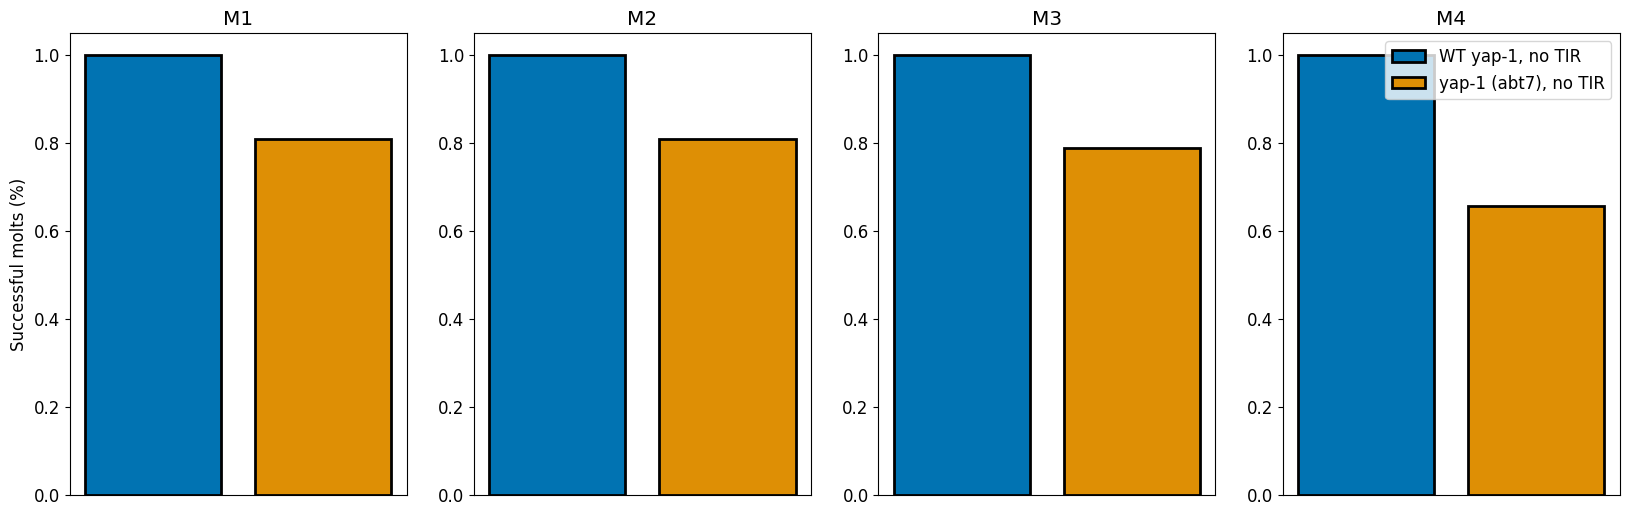

In [46]:
conditions_to_plot = [0, 4]
plot_developmental_success(conditions_struct, conditions_to_plot, legend = {'description': ''})

## yap-1 loss makes worms dumpy

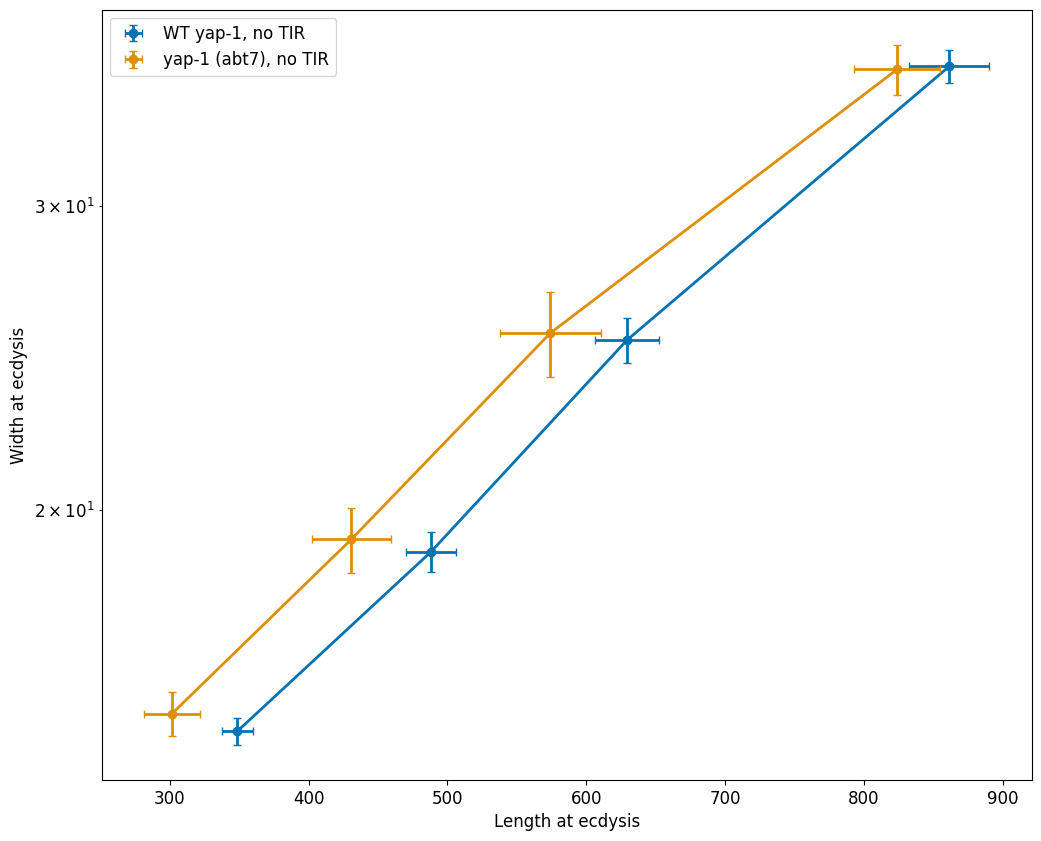

In [47]:
conditions_to_plot = [0, 4]
colors = None

plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', 'body_seg_str_width_mean_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (False, True), legend = {'description': ''}, y_axis_label='Width at ecdysis', x_axis_label='Length at ecdysis')

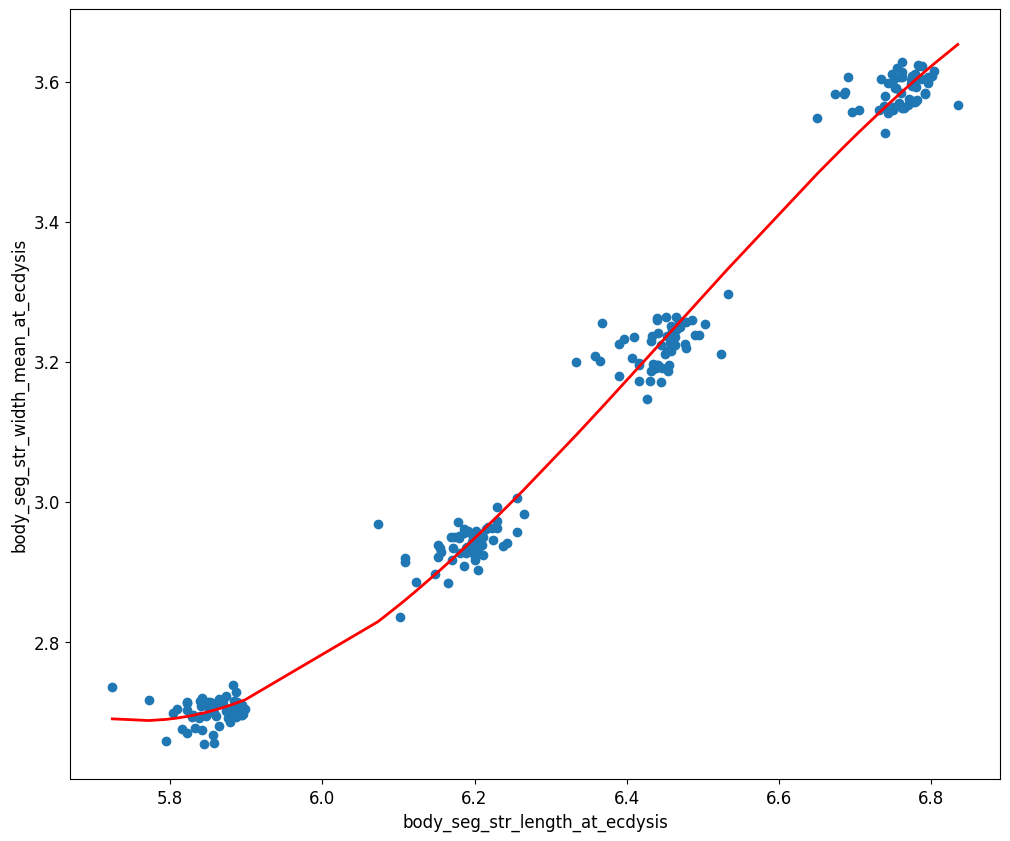

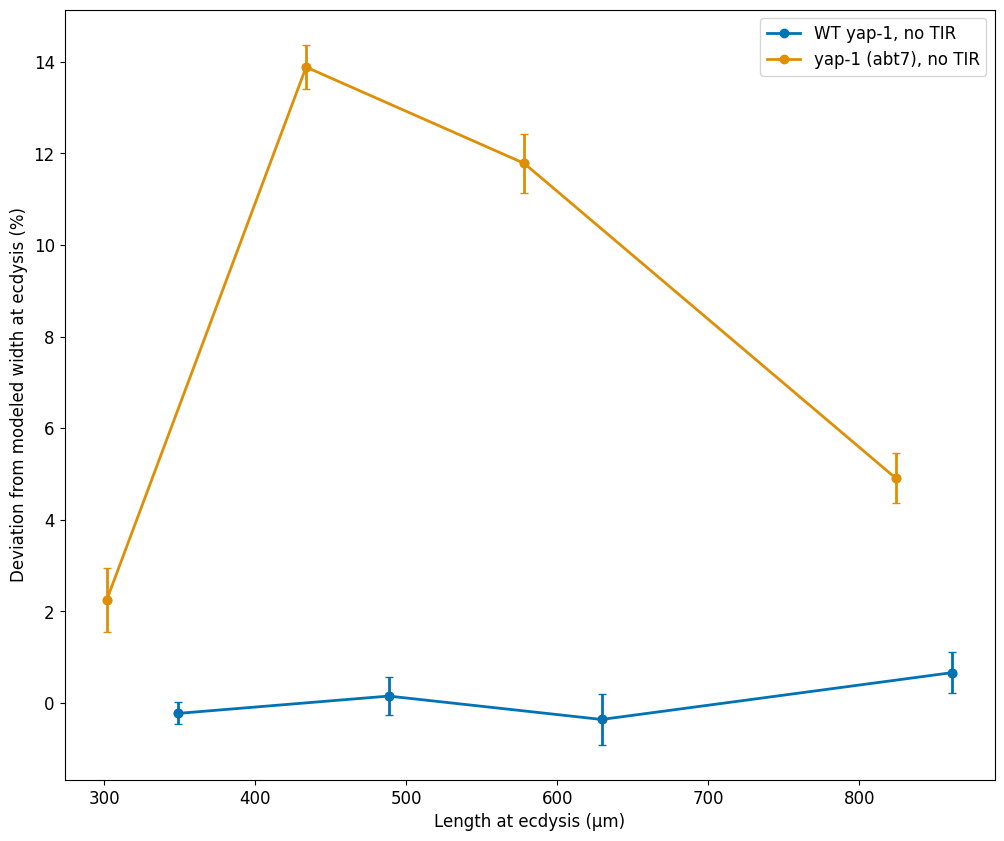

In [48]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_length_at_ecdysis", "body_seg_str_width_mean_at_ecdysis", control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = False, legend = {'description': ''}, x_axis_label='Length at ecdysis (µm)', y_axis_label='Deviation from modeled width at ecdysis (%)')

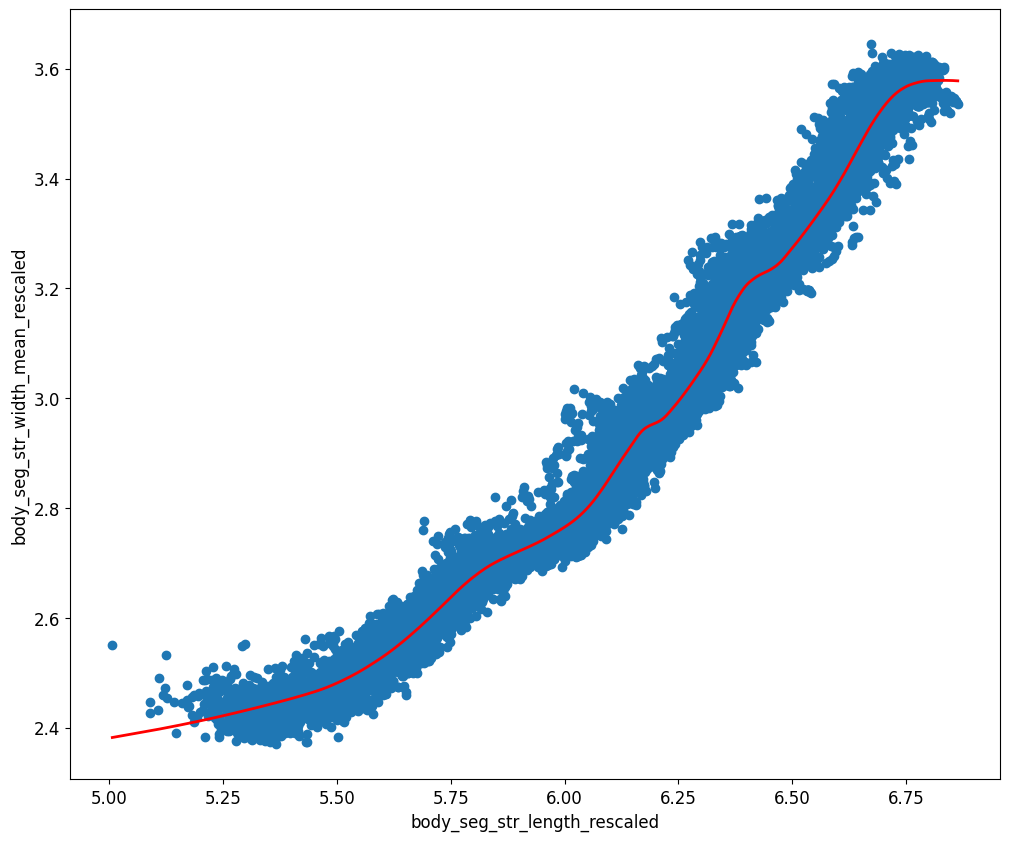

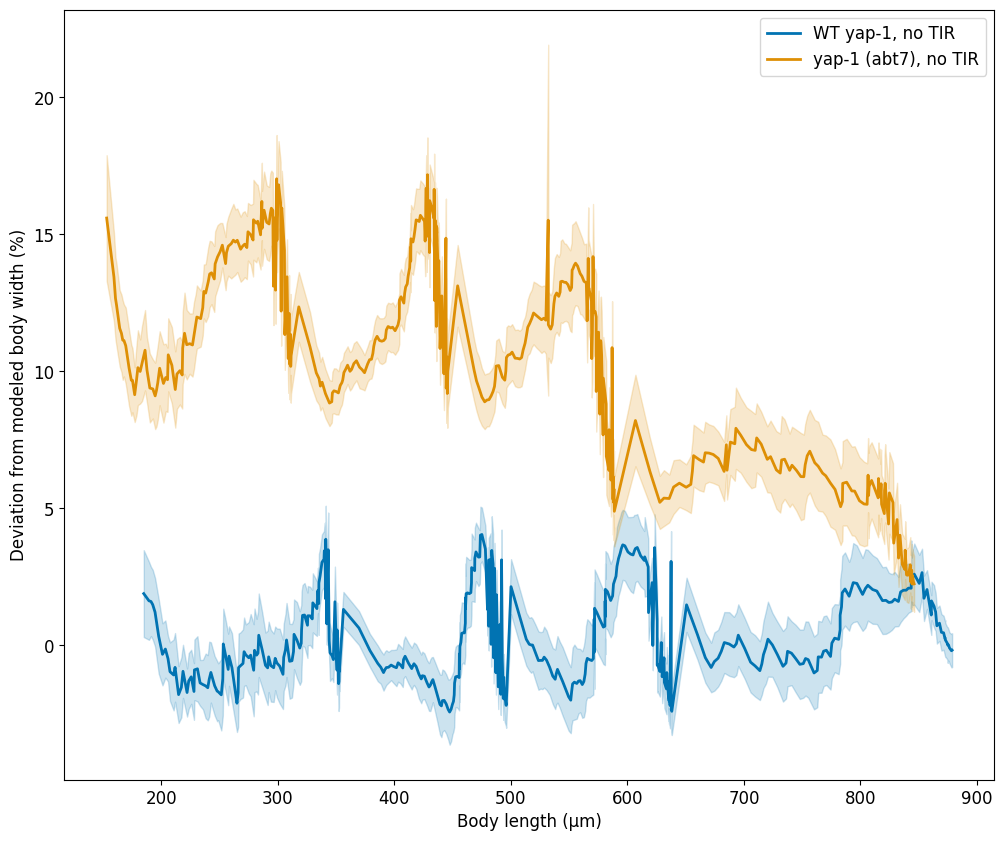

In [49]:
conditions_to_plot = [0, 4]
control_condition = 0
plot_deviation_from_model(conditions_struct, "body_seg_str_length_rescaled", "body_seg_str_width_mean_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = False, legend = {'description': ''}, x_axis_label='Body length (µm)', y_axis_label='Deviation from modeled body width (%)')

## yap-1 loss leads to width irregularities

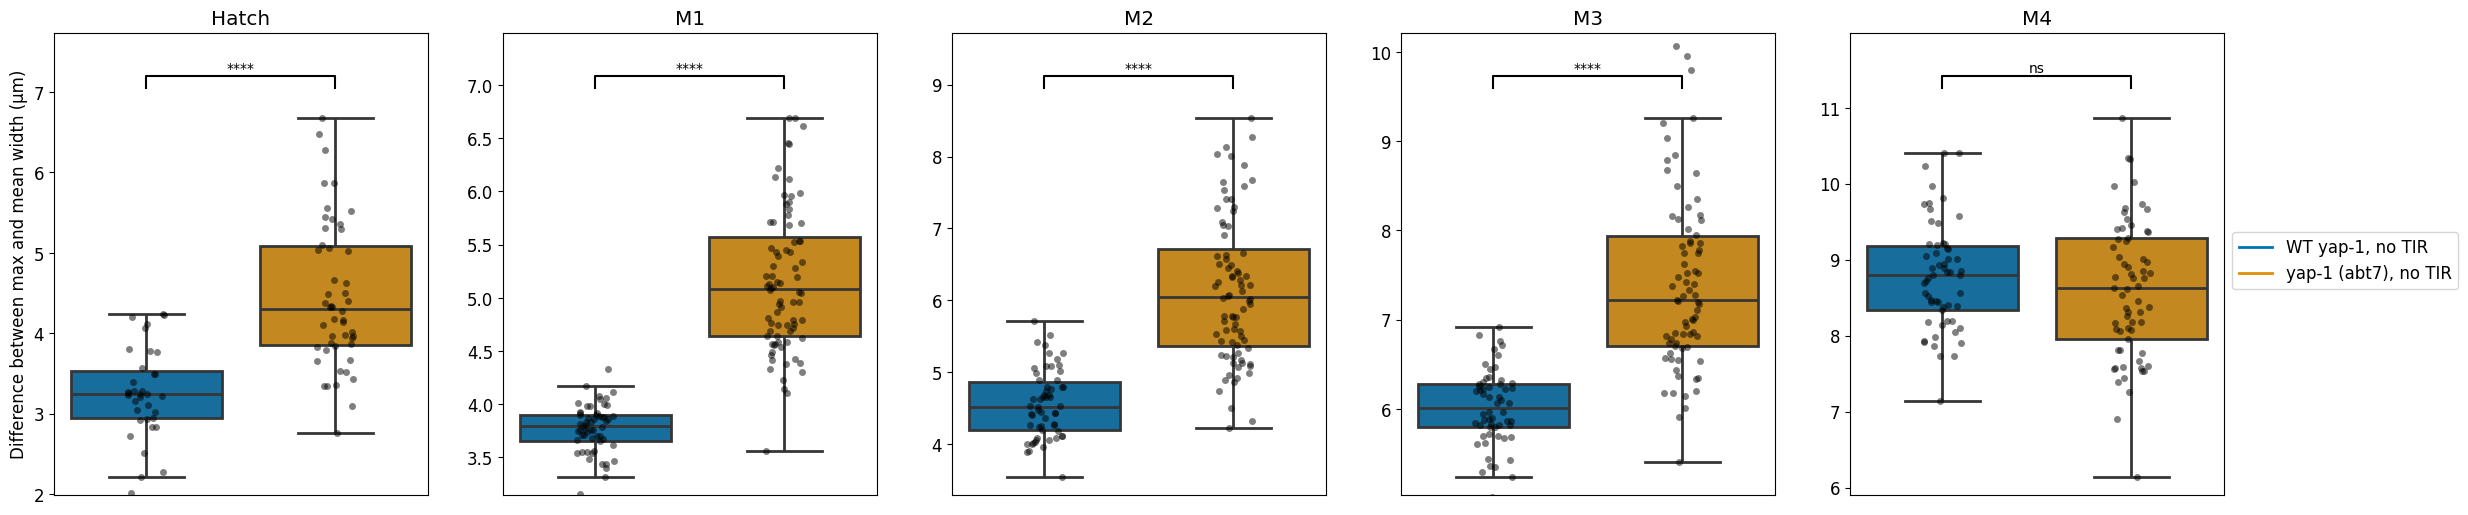

In [50]:
boxplot_at_molt(conditions_struct, 'body_seg_str_width_max_minus_mean_at_ecdysis', [0, 4], log_scale = False, plot_significance=True, legend = {'description': ''}, y_axis_label="Difference between max and mean width (µm)", titles = ['Hatch', 'M1', 'M2', 'M3', 'M4'])

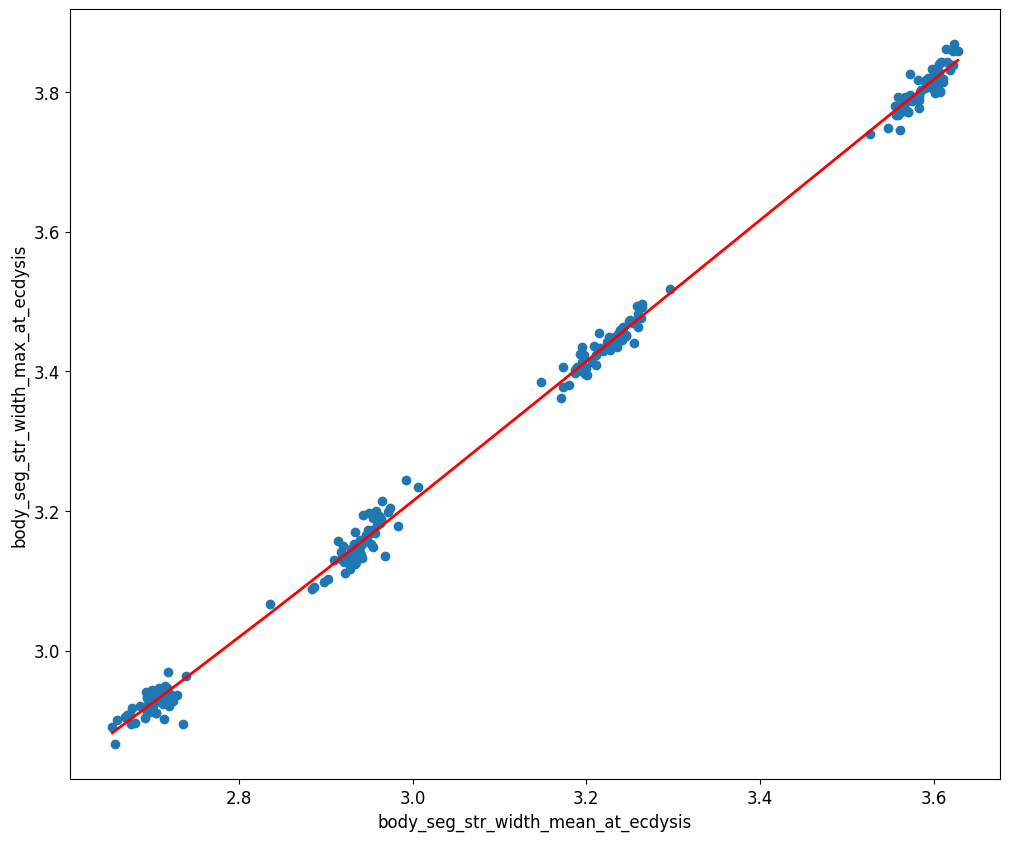

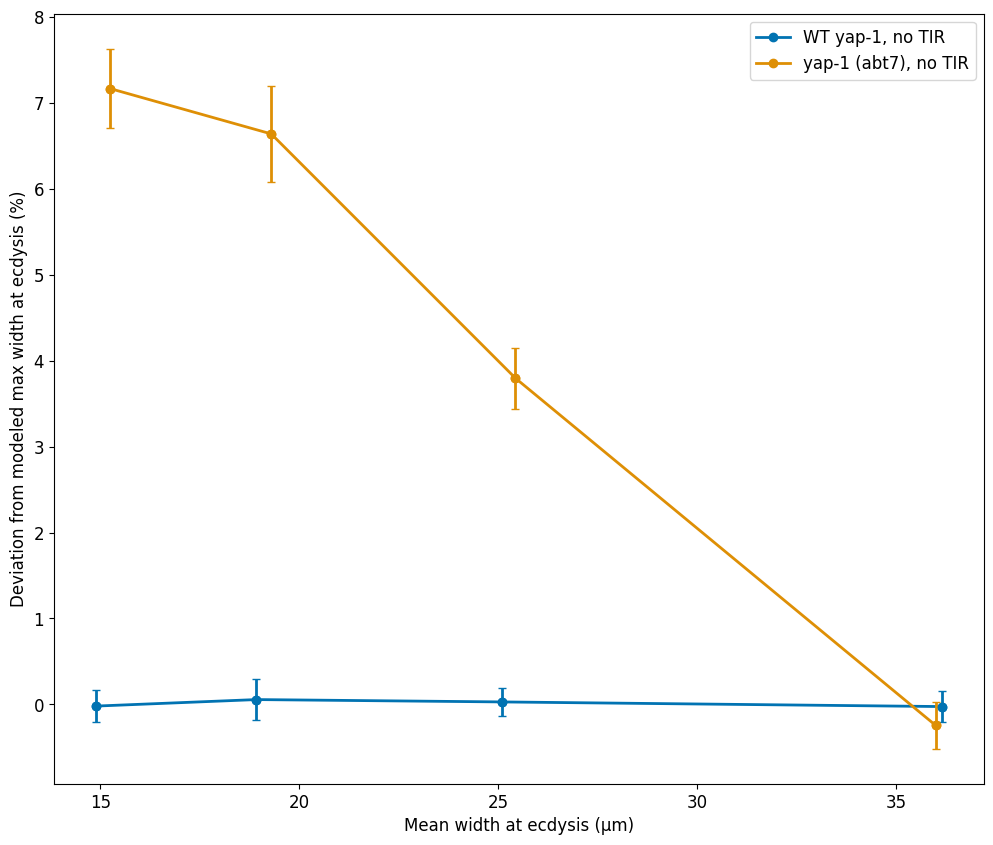

In [51]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_width_mean_at_ecdysis", "body_seg_str_width_max_at_ecdysis", control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = False, legend = {'description': ''}, x_axis_label='Mean width at ecdysis (µm)', y_axis_label='Deviation from modeled max width at ecdysis (%)')

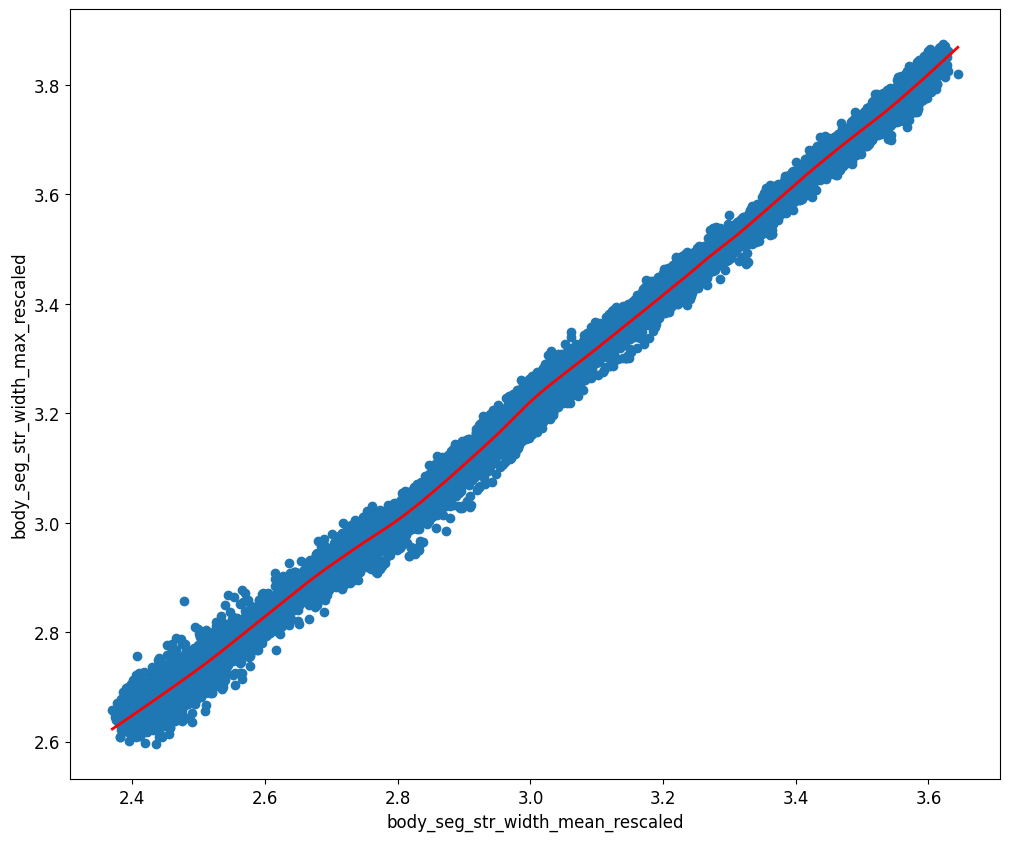

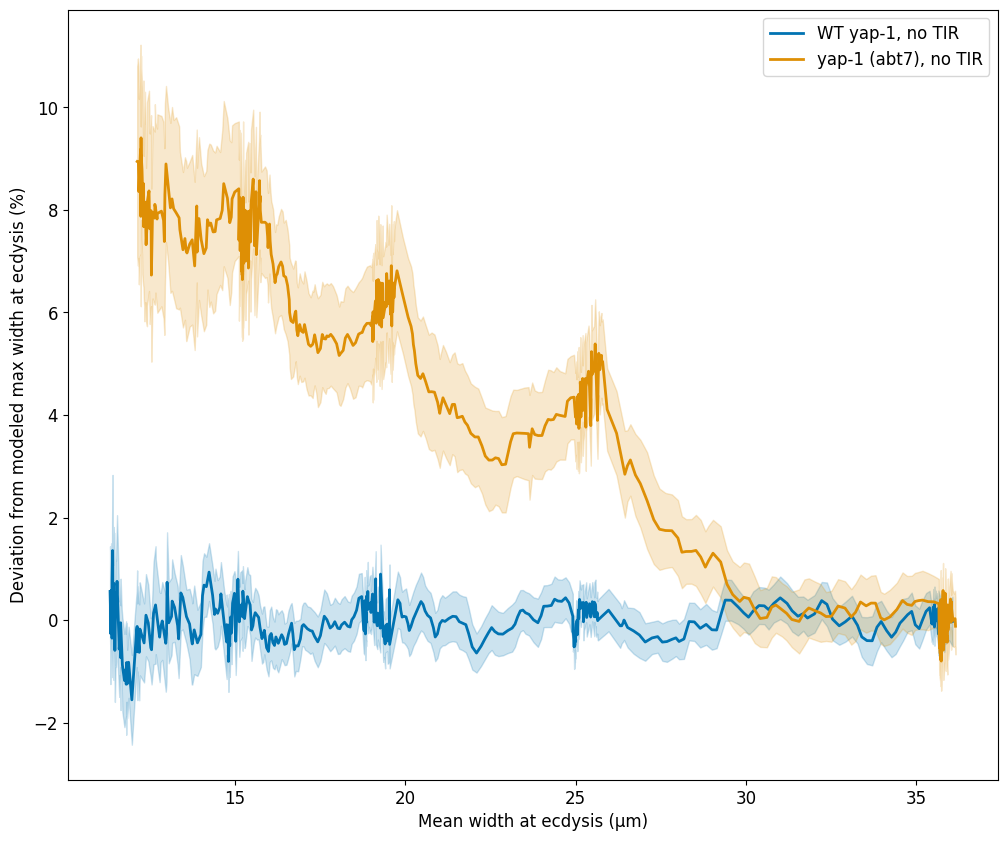

In [52]:
conditions_to_plot = [0, 4]
control_condition = 0
plot_deviation_from_model(conditions_struct, "body_seg_str_width_mean_rescaled", "body_seg_str_width_max_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = False, legend = {'description': ''}, x_axis_label='Mean width at ecdysis (µm)', y_axis_label='Deviation from modeled max width at ecdysis (%)')

## yap-1 deletion makes body shape more heterogenious

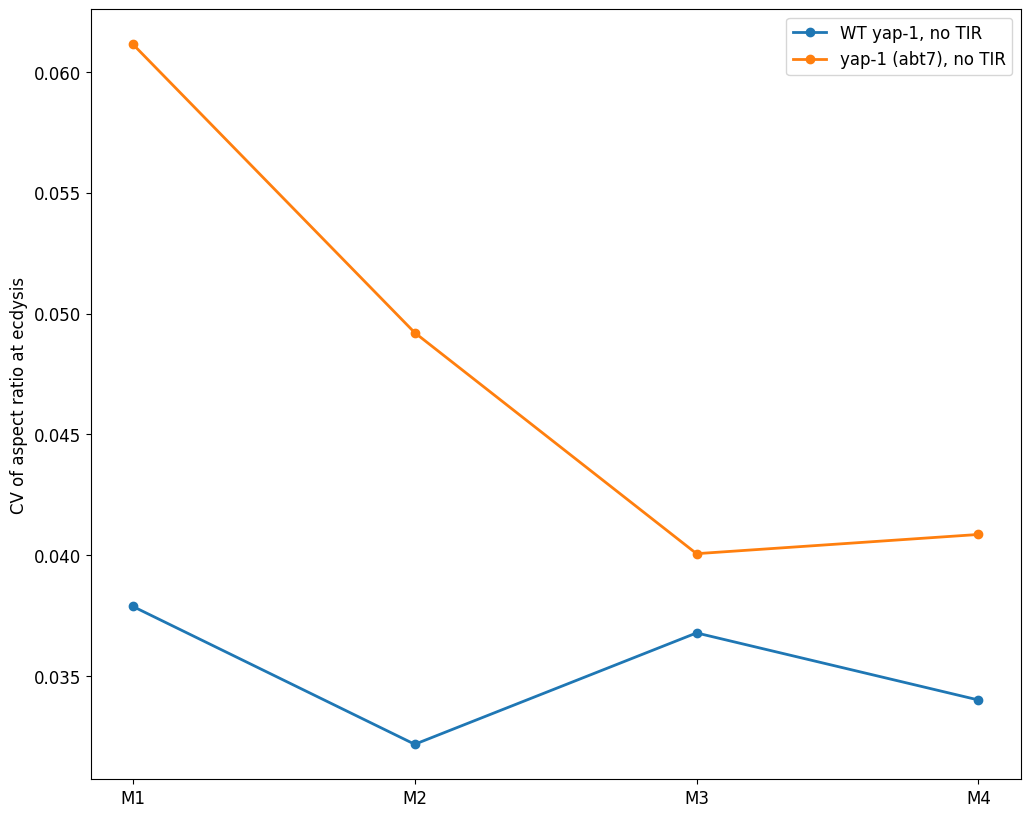

In [53]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_aspect_ratio_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of aspect ratio at ecdysis')   

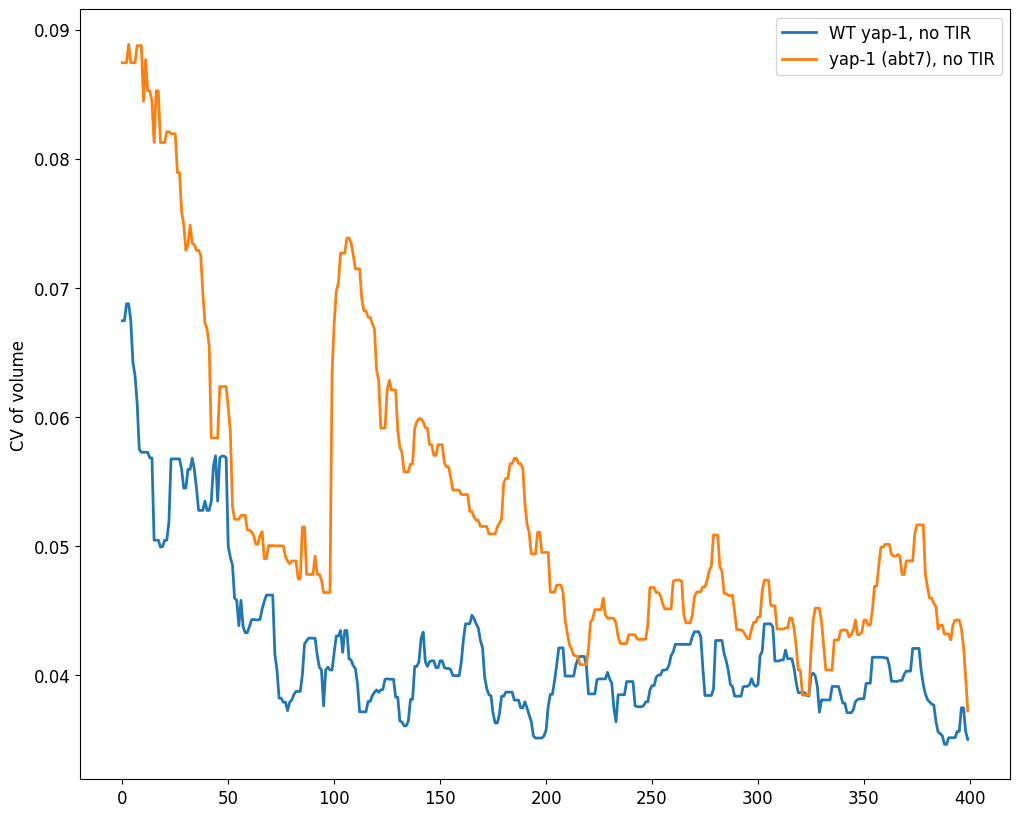

In [54]:
plot_heterogeneity_rescaled_data(conditions_struct, 'body_seg_str_aspect_ratio_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of volume') 

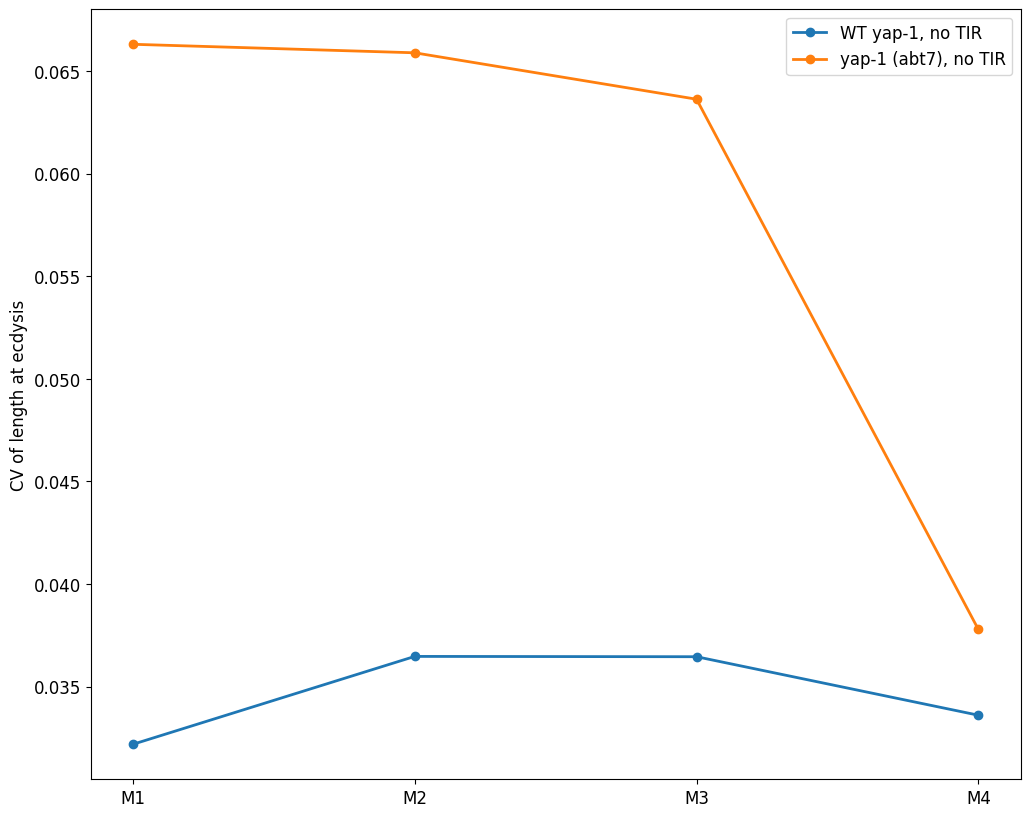

In [55]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of length at ecdysis')   

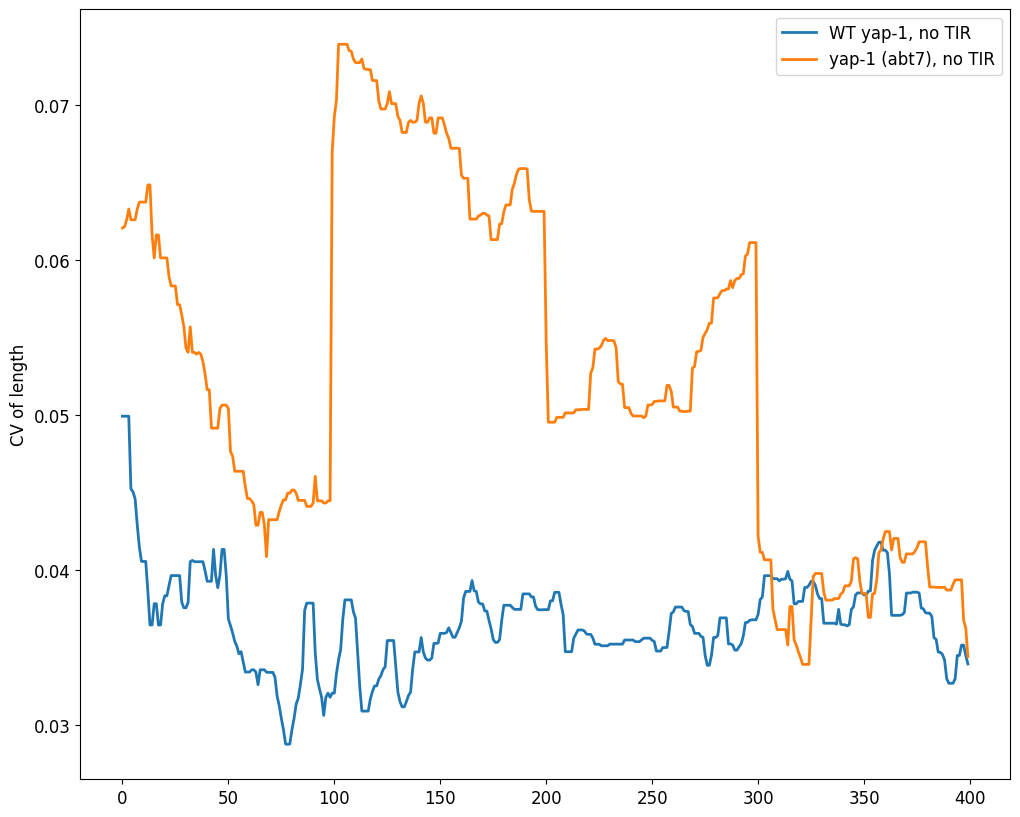

In [56]:
plot_heterogeneity_rescaled_data(conditions_struct, 'body_seg_str_length_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of length') 

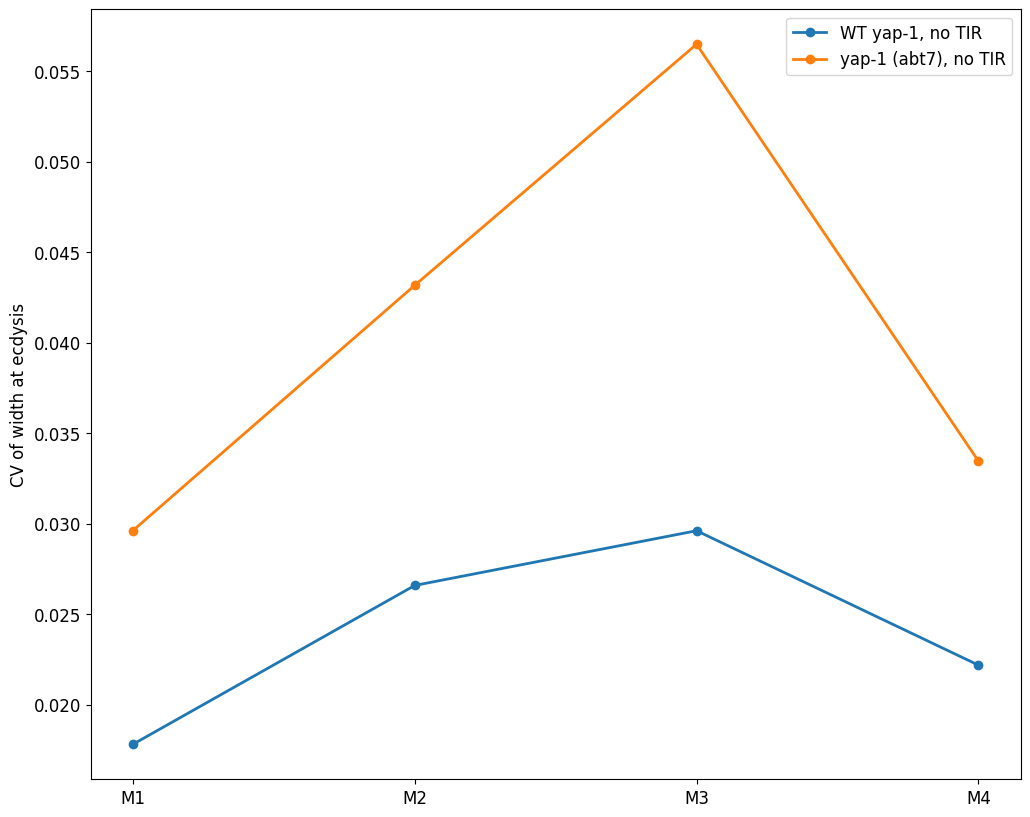

In [57]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_width_mean_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of width at ecdysis')   

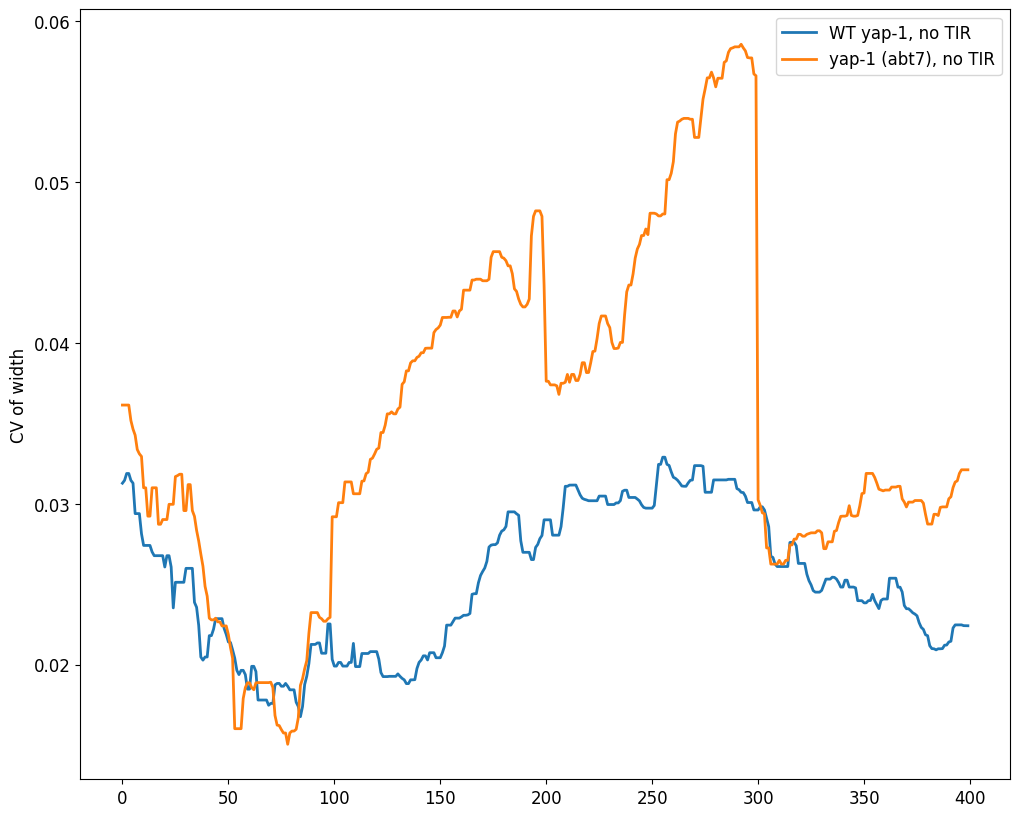

In [58]:
plot_heterogeneity_rescaled_data(conditions_struct, 'body_seg_str_width_mean_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of width')   

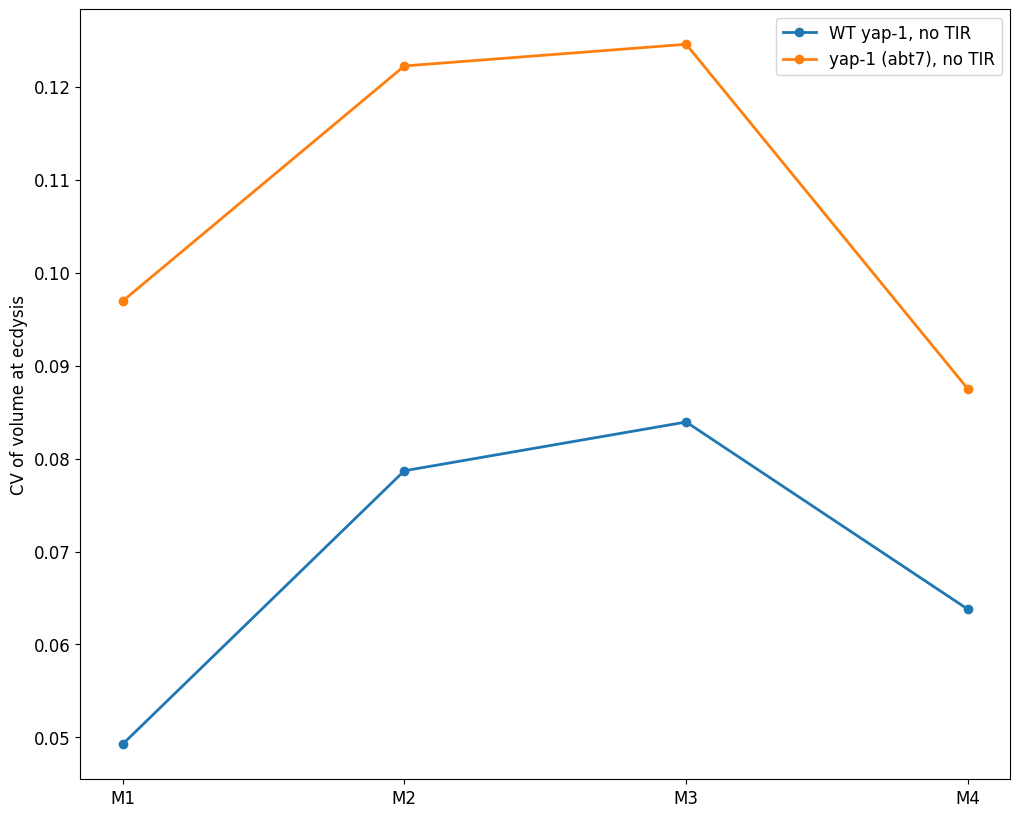

In [59]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of volume at ecdysis')   

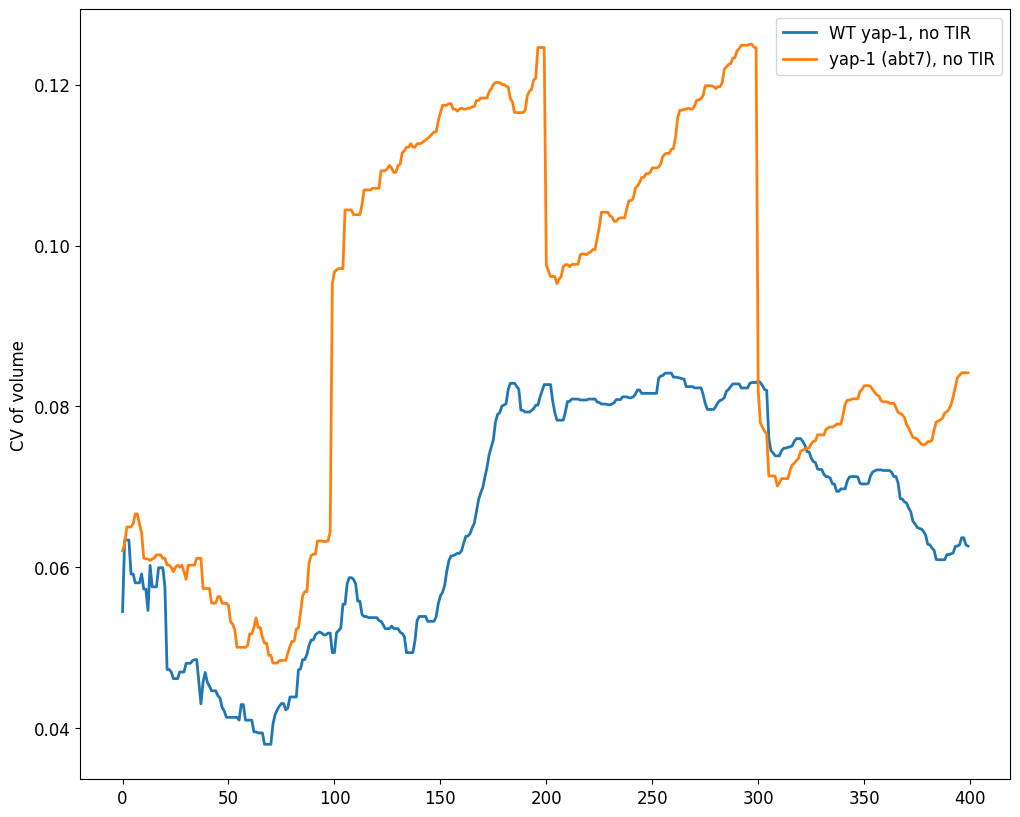

In [60]:
plot_heterogeneity_rescaled_data(conditions_struct, 'body_seg_str_volume_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of volume') 

## yap-1 loss doesn’t affect pharynx/body volume proportions

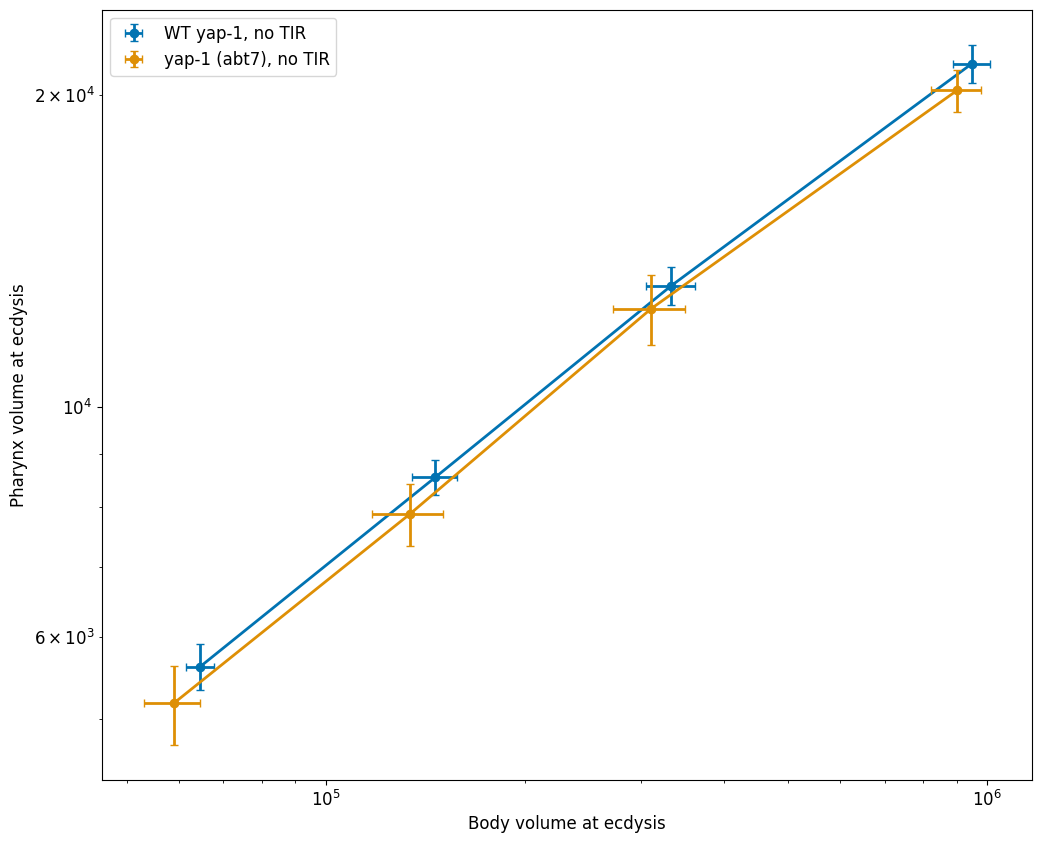

In [61]:
conditions_to_plot = [0, 4]
colors = None


plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', 'pharynx_seg_str_volume_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (True, True), legend = {'description': ''}, x_axis_label='Body volume at ecdysis', y_axis_label='Pharynx volume at ecdysis')

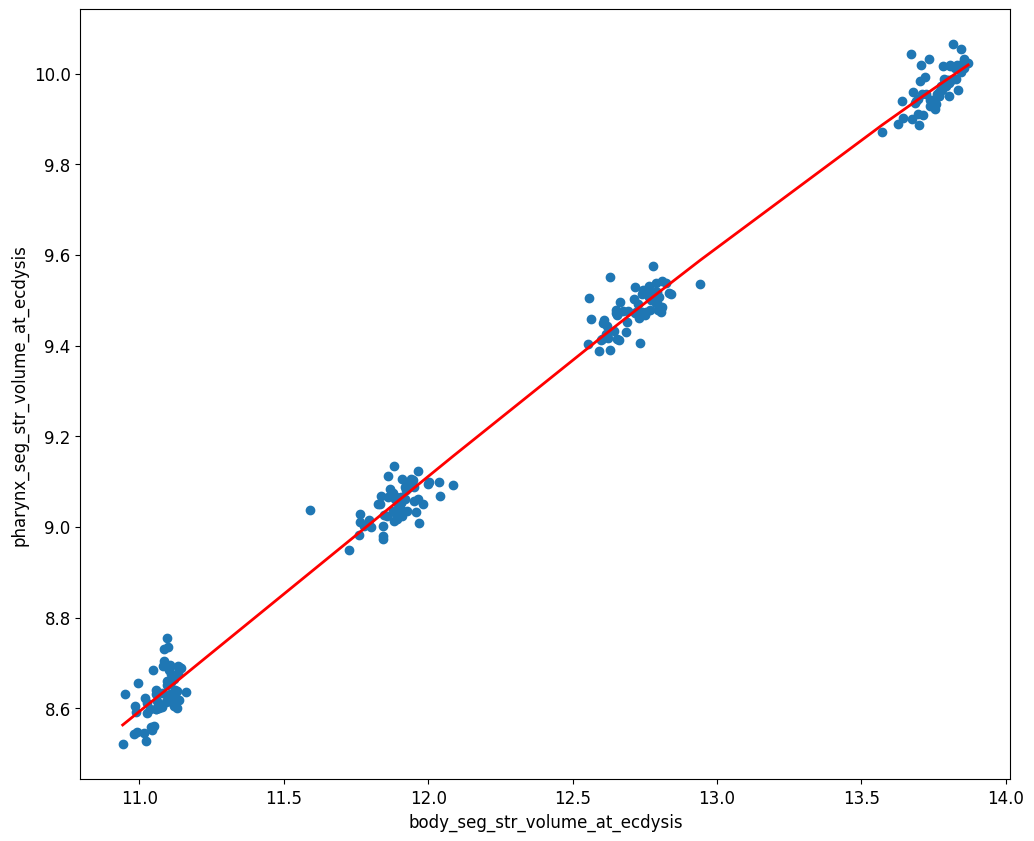

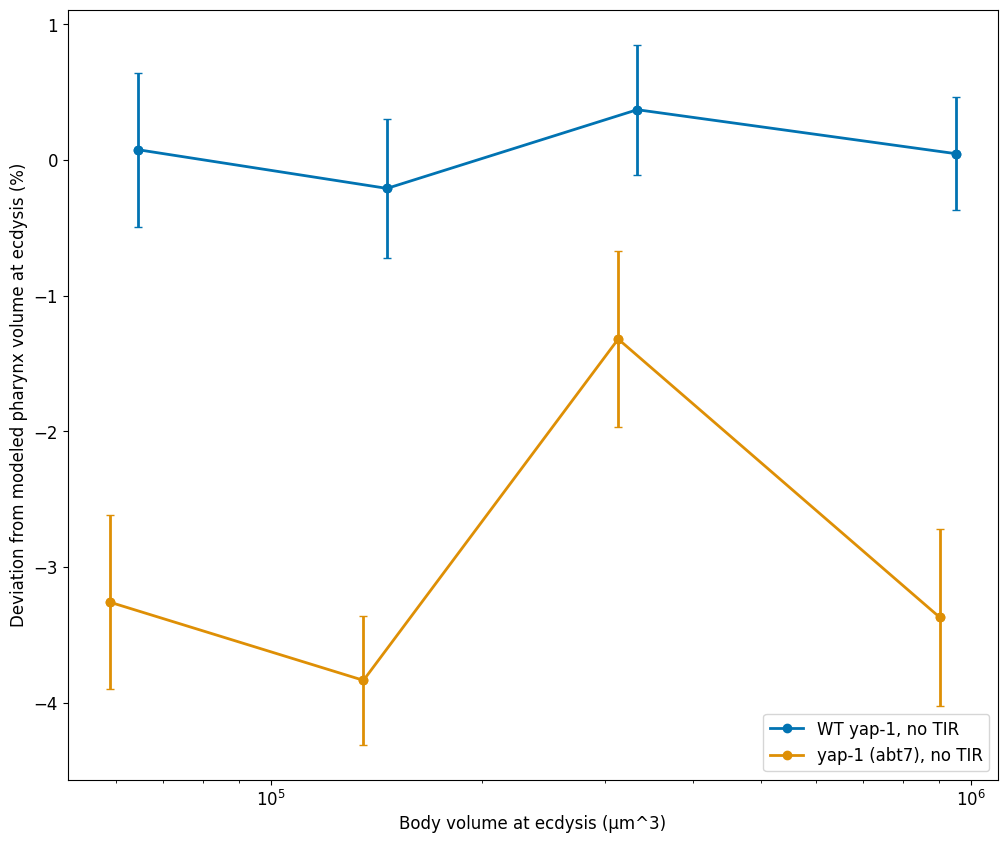

In [62]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', 'pharynx_seg_str_volume_at_ecdysis', control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Body volume at ecdysis (µm^3)', y_axis_label='Deviation from modeled pharynx volume at ecdysis (%)')

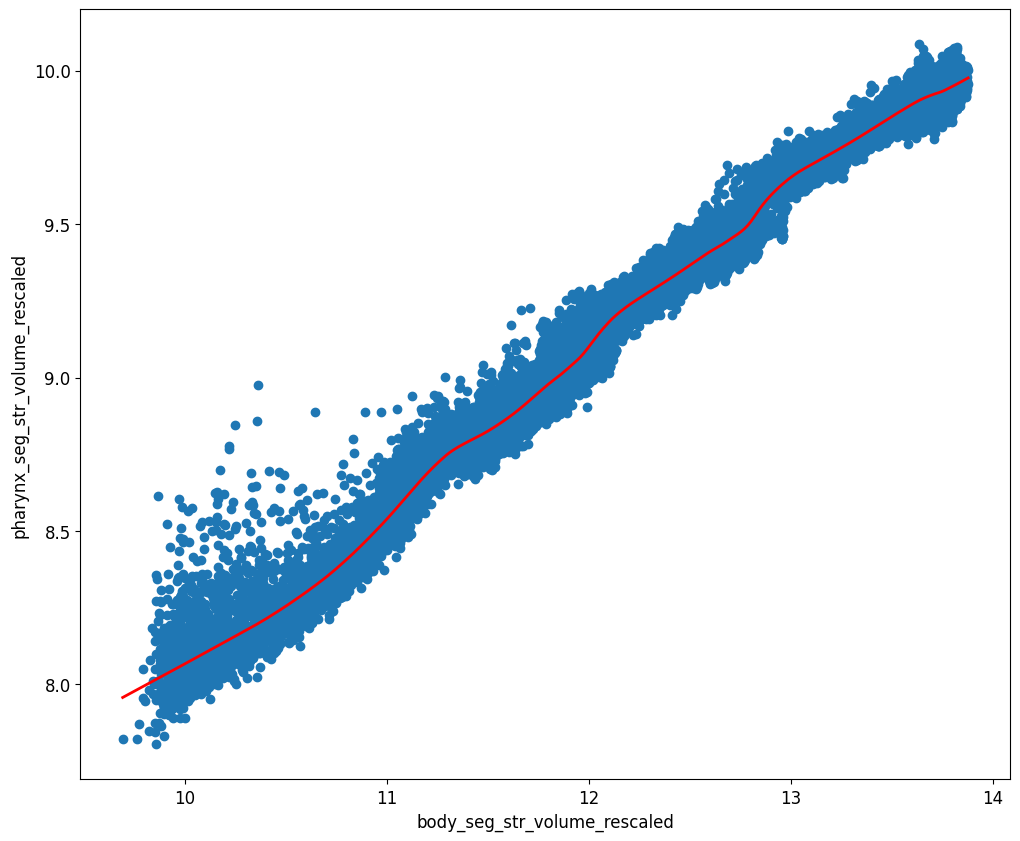

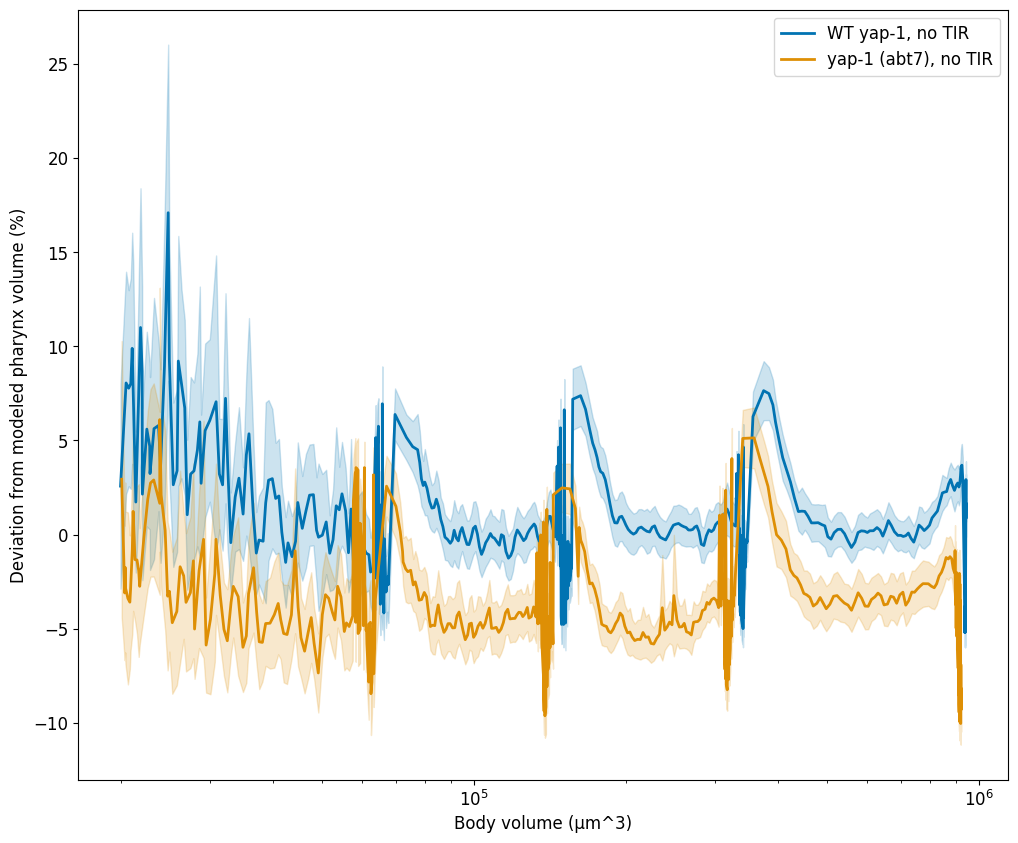

In [63]:
conditions_to_plot = [0, 4]
control_condition = 0

plot_deviation_from_model(conditions_struct, "body_seg_str_volume_rescaled", "pharynx_seg_str_volume_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Body volume (µm^3)', y_axis_label='Deviation from modeled pharynx volume (%)')

## yap-1 loss makes pharynxes too short for their respective body length

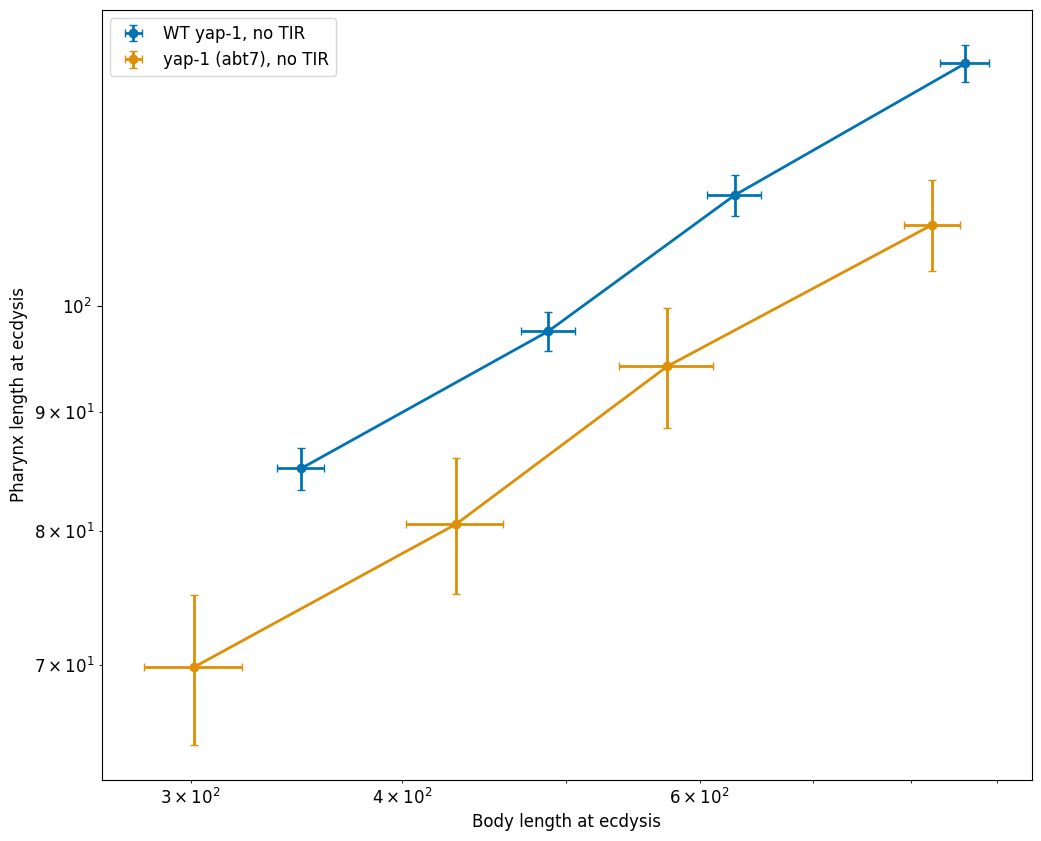

In [64]:
conditions_to_plot = [0, 4]
colors = None


plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (True, True), legend = {'description': ''}, x_axis_label='Body length at ecdysis', y_axis_label='Pharynx length at ecdysis')

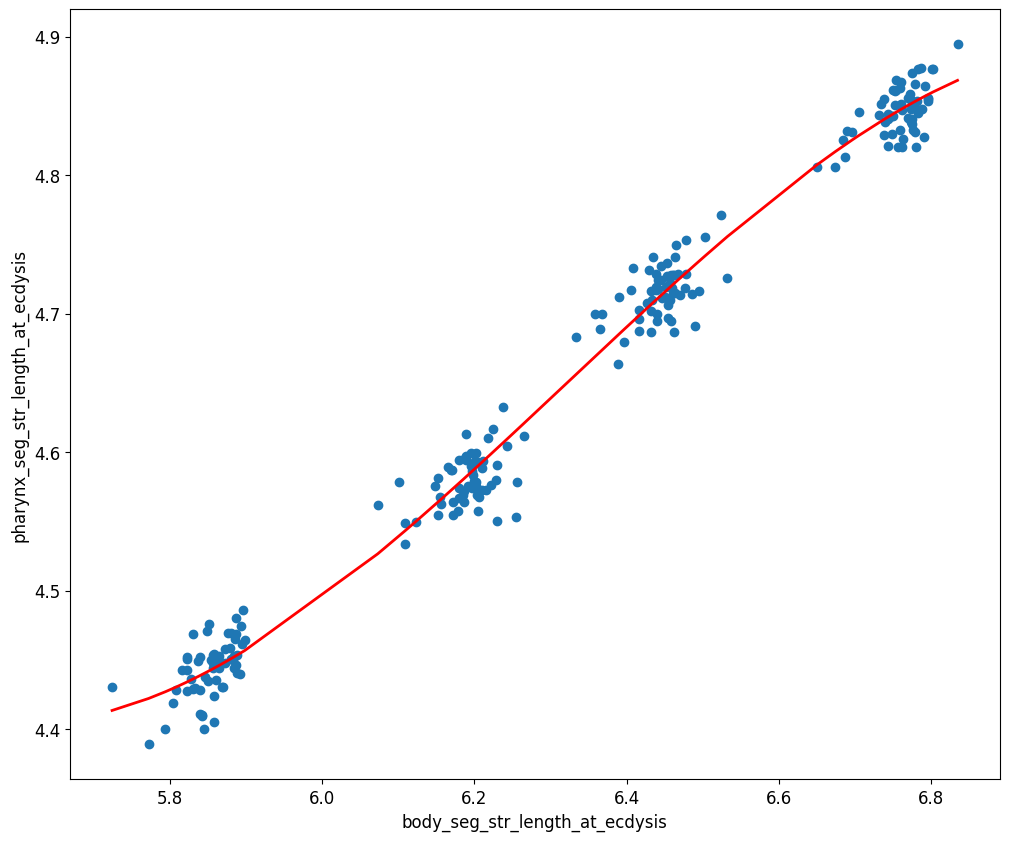

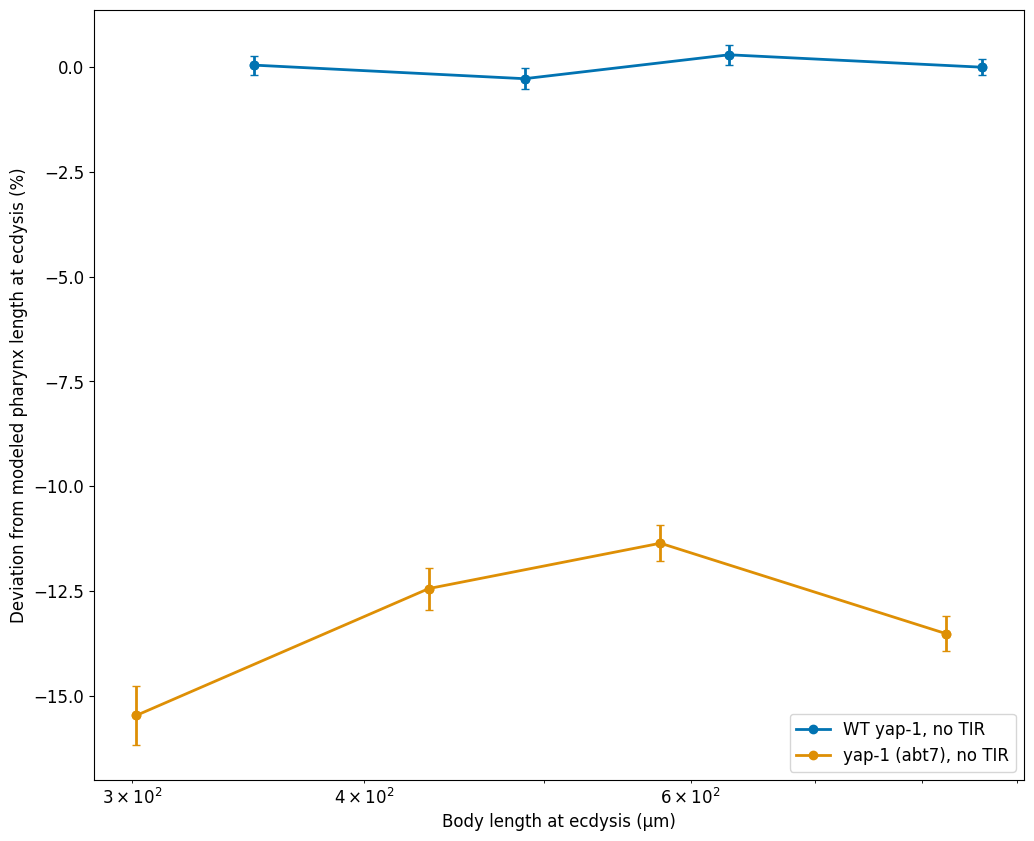

In [65]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Body length at ecdysis (µm)', y_axis_label='Deviation from modeled pharynx length at ecdysis (%)')

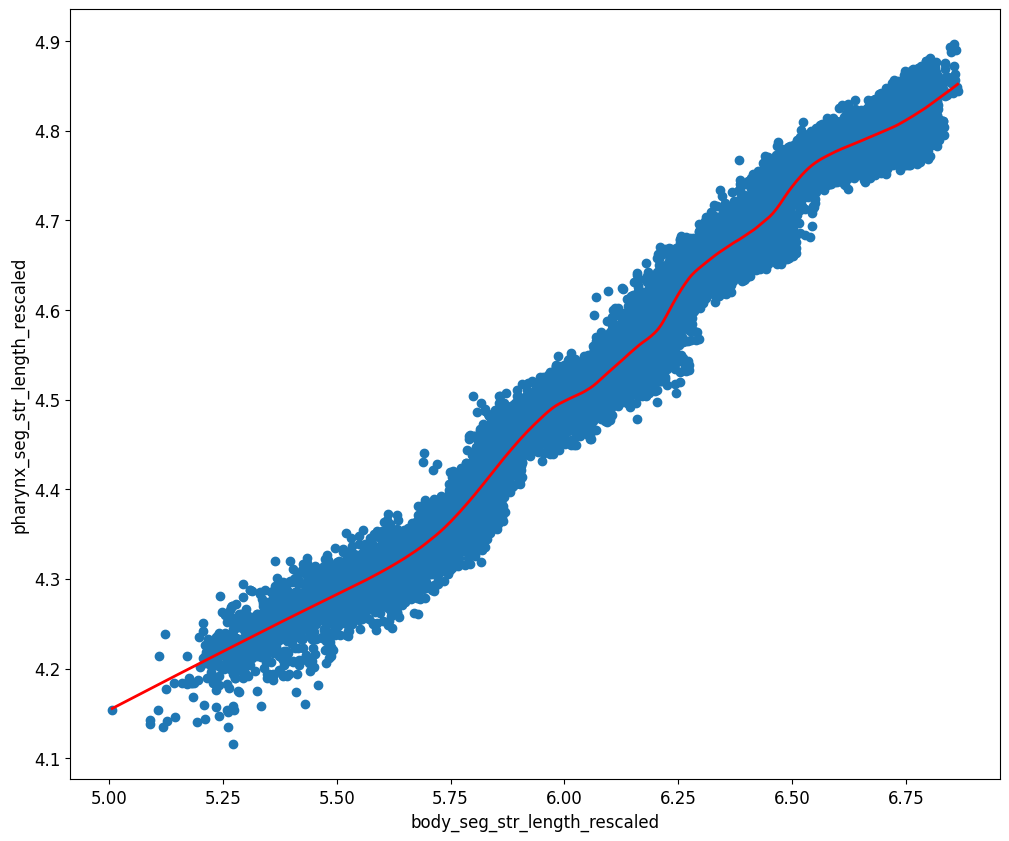

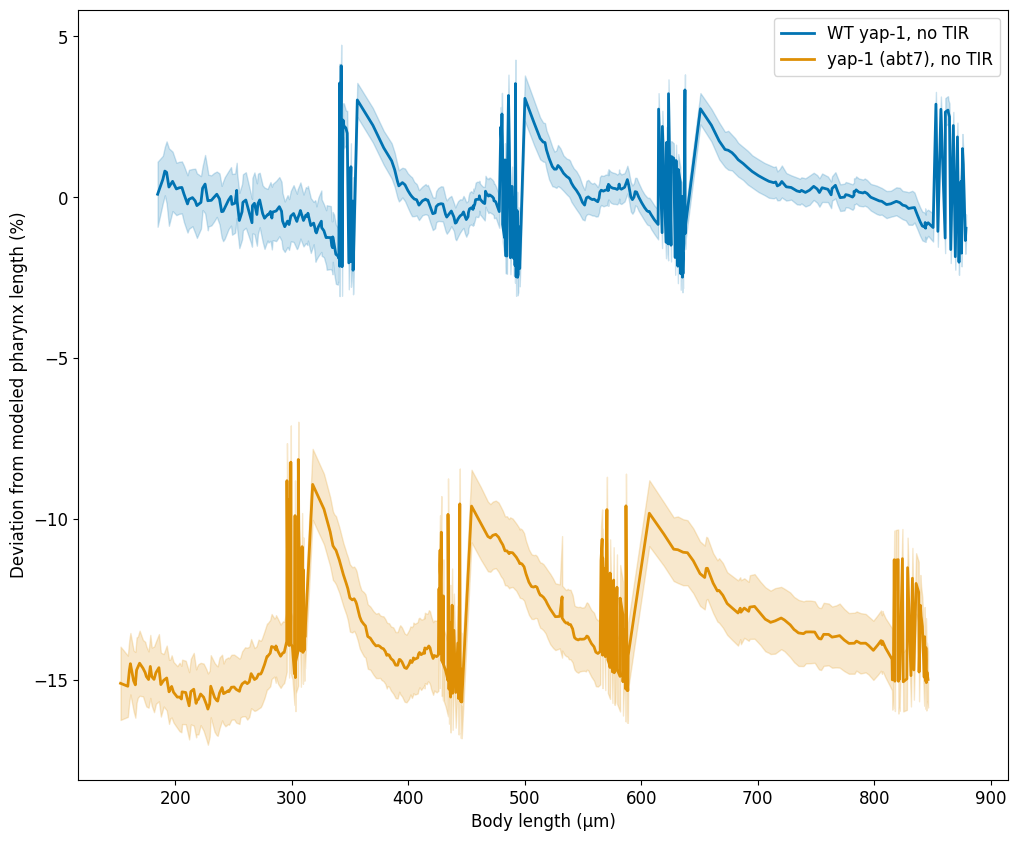

In [66]:
conditions_to_plot = [0, 4]
control_condition = 0

plot_deviation_from_model(conditions_struct, "body_seg_str_length_rescaled", "pharynx_seg_str_length_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = False, legend = {'description': ''}, x_axis_label='Body length (µm)', y_axis_label='Deviation from modeled pharynx length (%)')

## yap-1 loss makes pharynxes dumpy

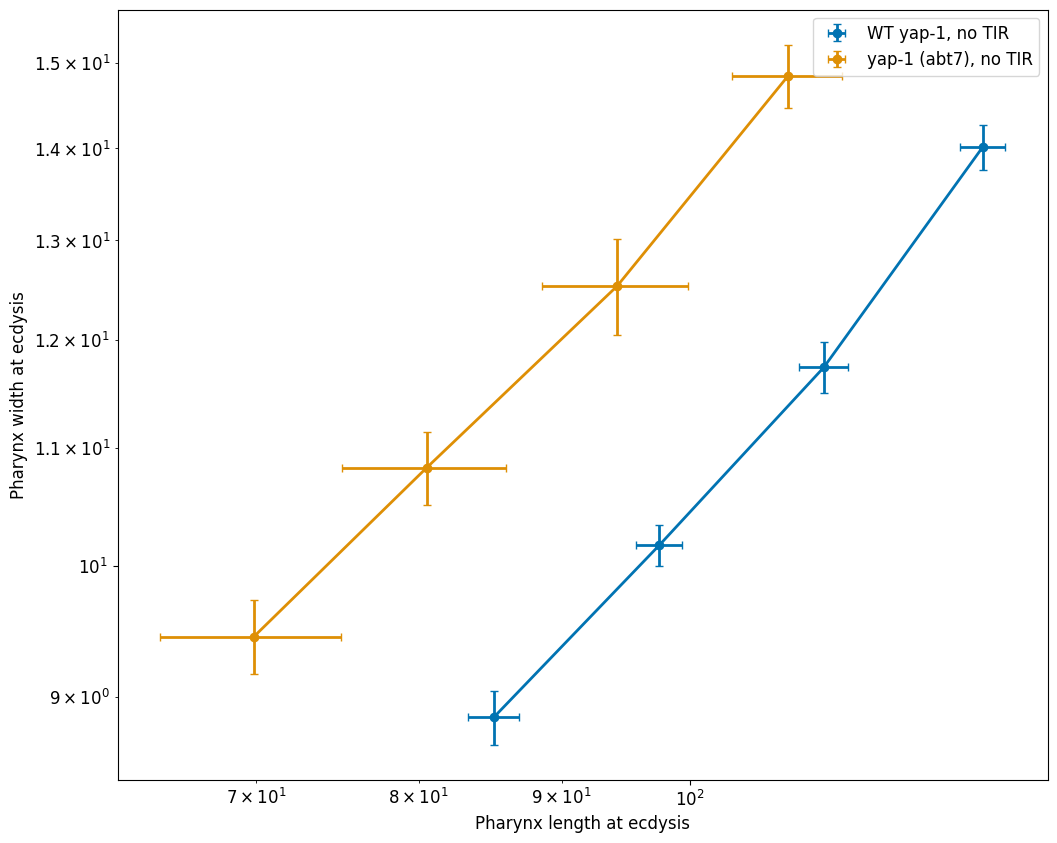

In [67]:
conditions_to_plot = [0, 4]
colors = None


plot_correlation_at_ecdysis(conditions_struct, 'pharynx_seg_str_length_at_ecdysis', 'pharynx_seg_str_width_mean_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (True, True), legend = {'description': ''}, x_axis_label='Pharynx length at ecdysis', y_axis_label='Pharynx width at ecdysis')

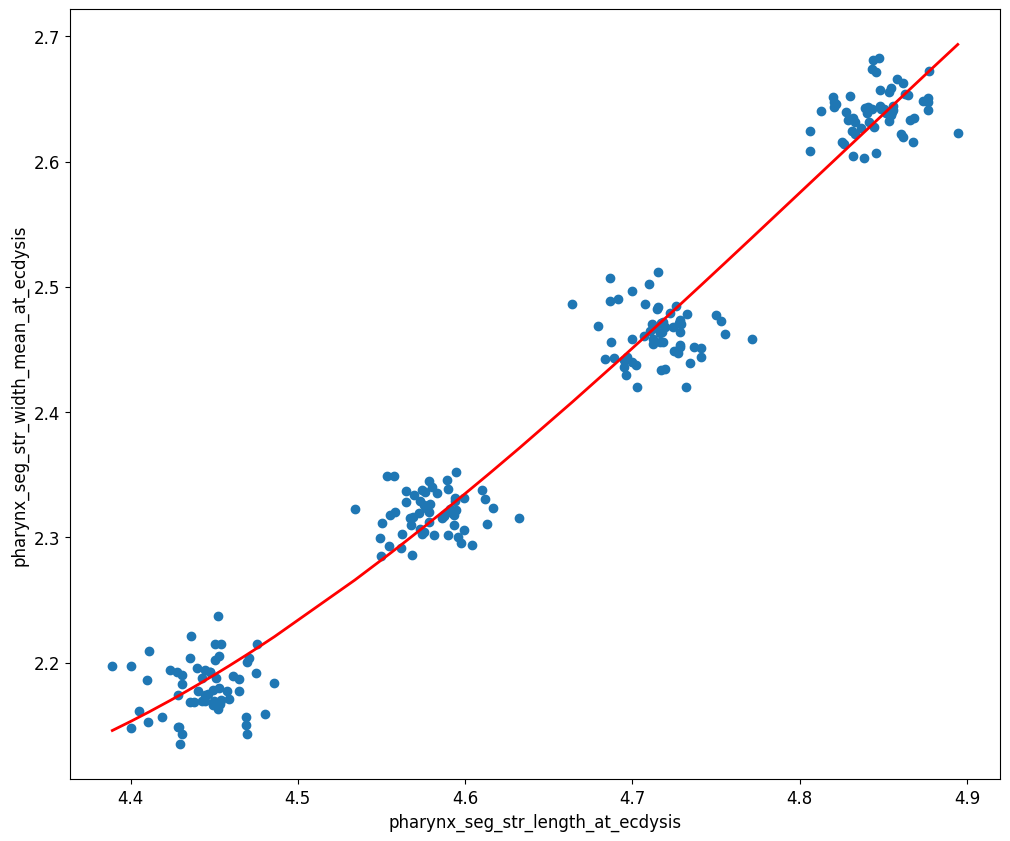

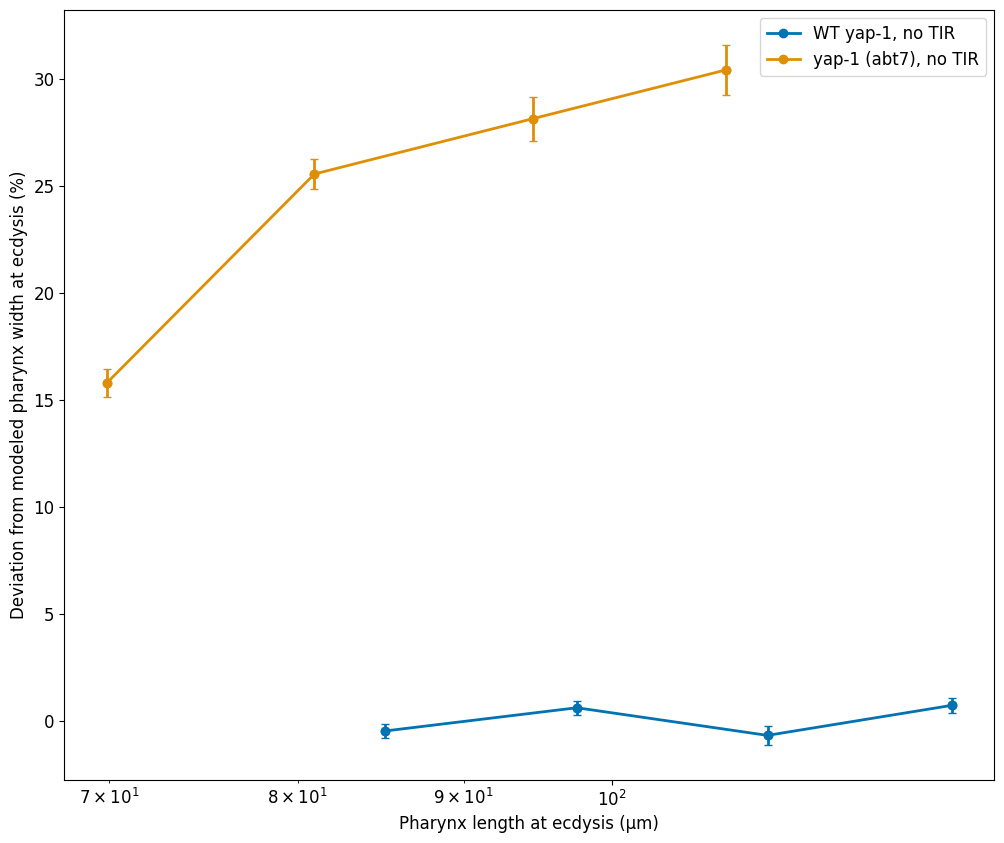

In [68]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, 'pharynx_seg_str_length_at_ecdysis', 'pharynx_seg_str_width_mean_at_ecdysis', control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Pharynx length at ecdysis (µm)', y_axis_label='Deviation from modeled pharynx width at ecdysis (%)')

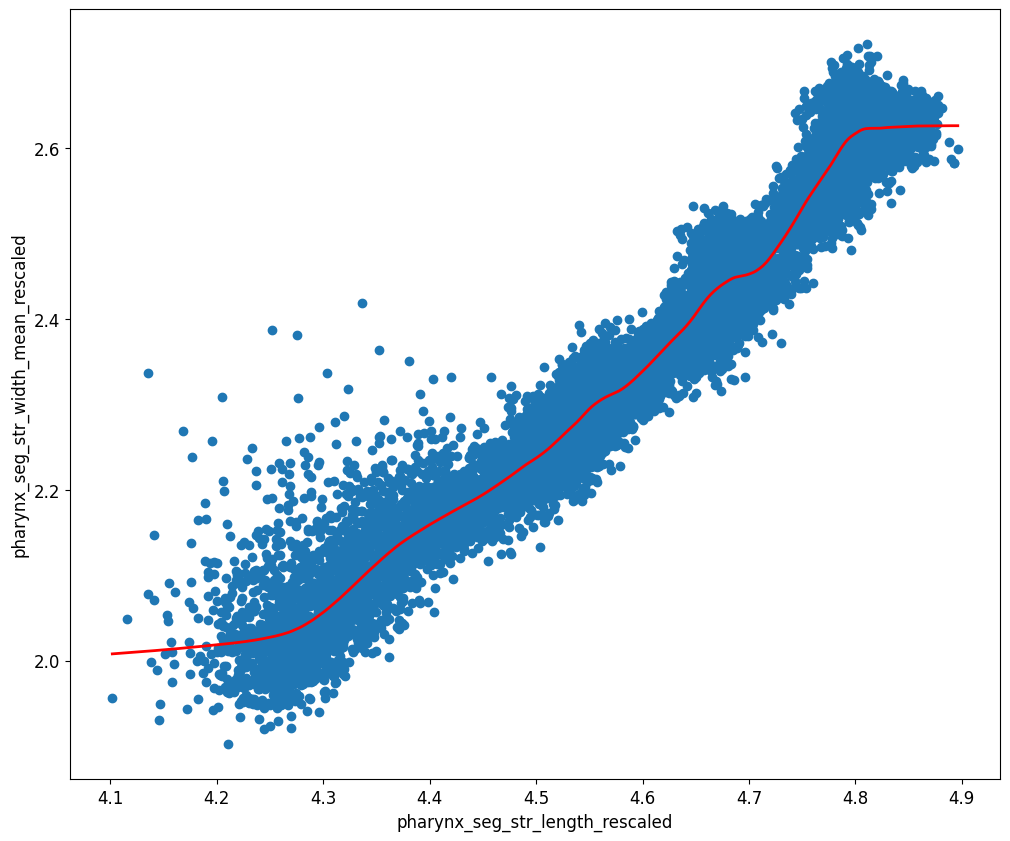

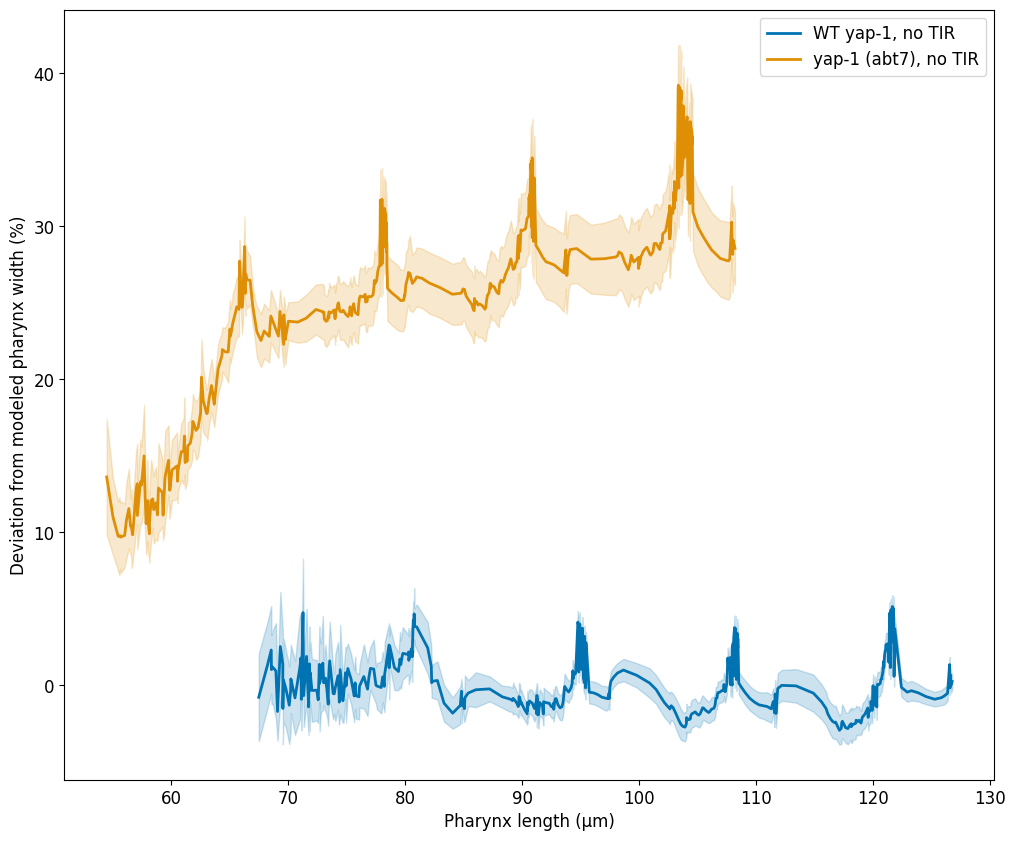

In [69]:
conditions_to_plot = [0, 4]
plot_deviation_from_model(conditions_struct, "pharynx_seg_str_length_rescaled", "pharynx_seg_str_width_mean_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = False, legend = {'description': ''}, x_axis_label='Pharynx length (µm)', y_axis_label='Deviation from modeled pharynx width (%)')

## yap-1 deletion makes pharynx shape more heterogenious

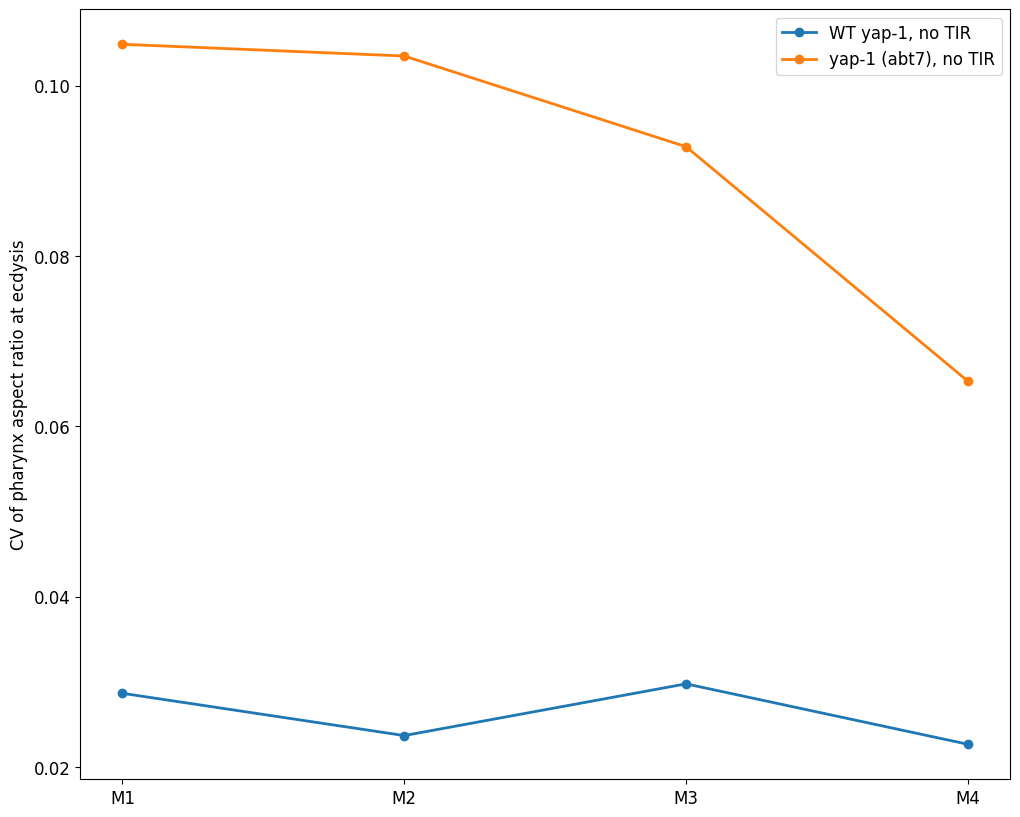

In [84]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'pharynx_seg_str_aspect_ratio_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx aspect ratio at ecdysis')   

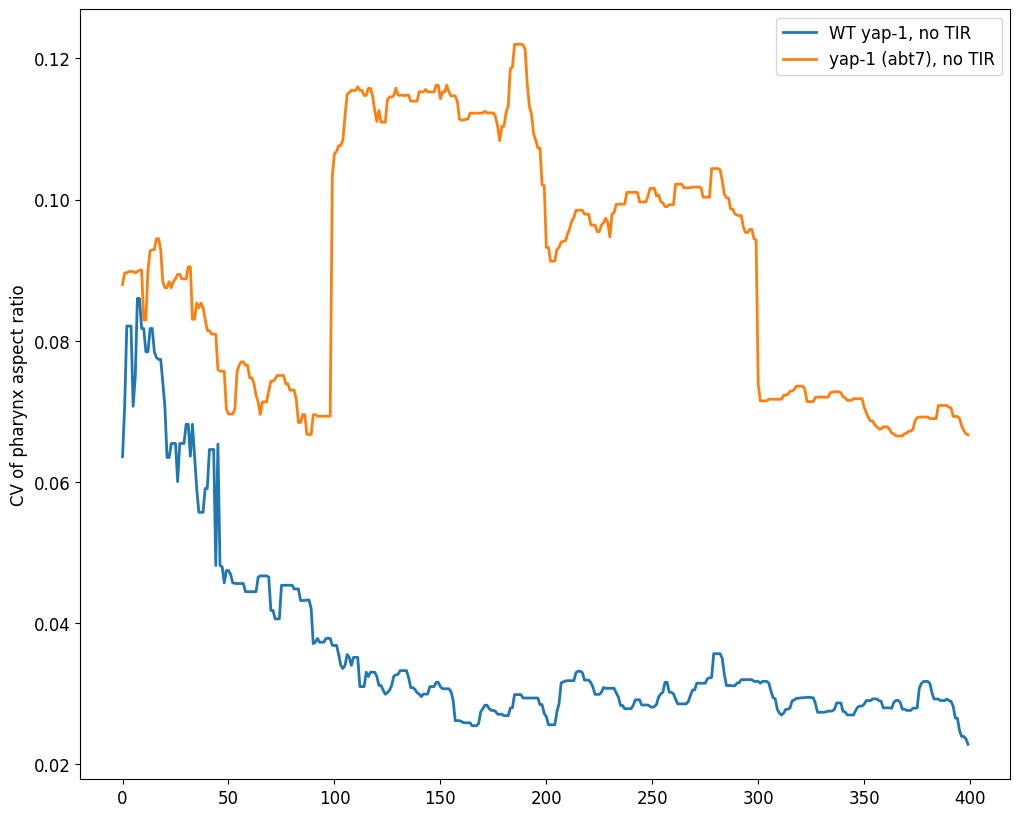

In [85]:
plot_heterogeneity_rescaled_data(conditions_struct, 'pharynx_seg_str_aspect_ratio_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx aspect ratio') 

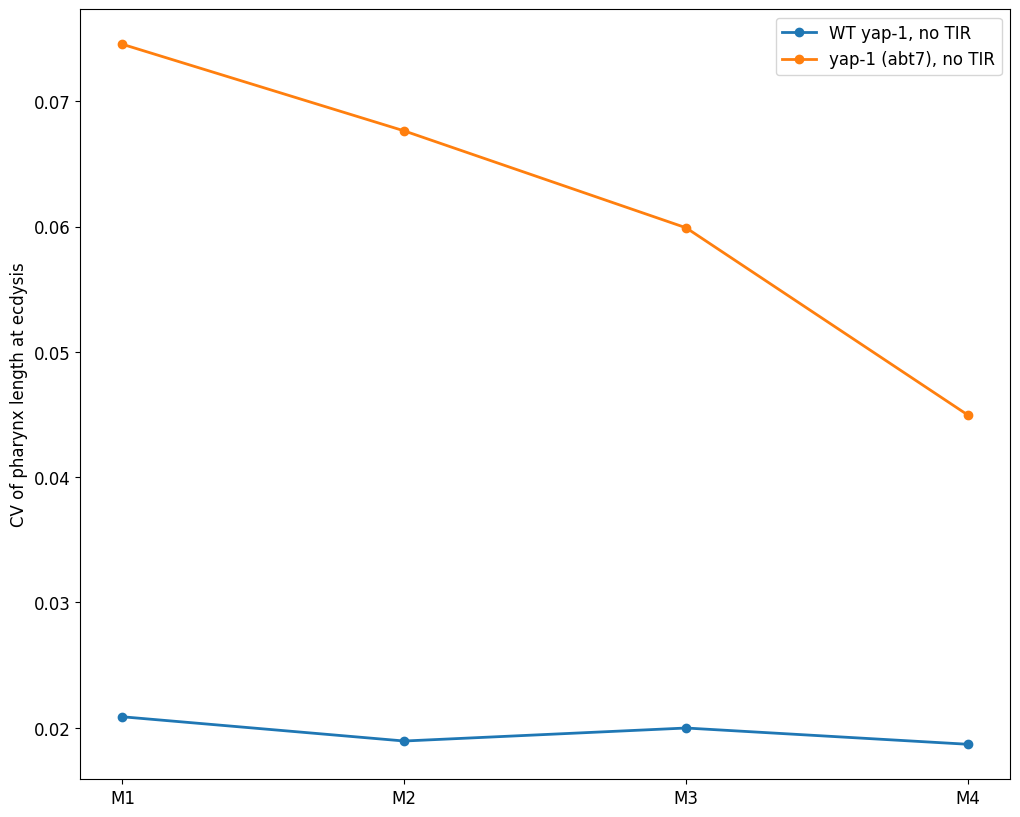

In [86]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'pharynx_seg_str_length_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx length at ecdysis')   

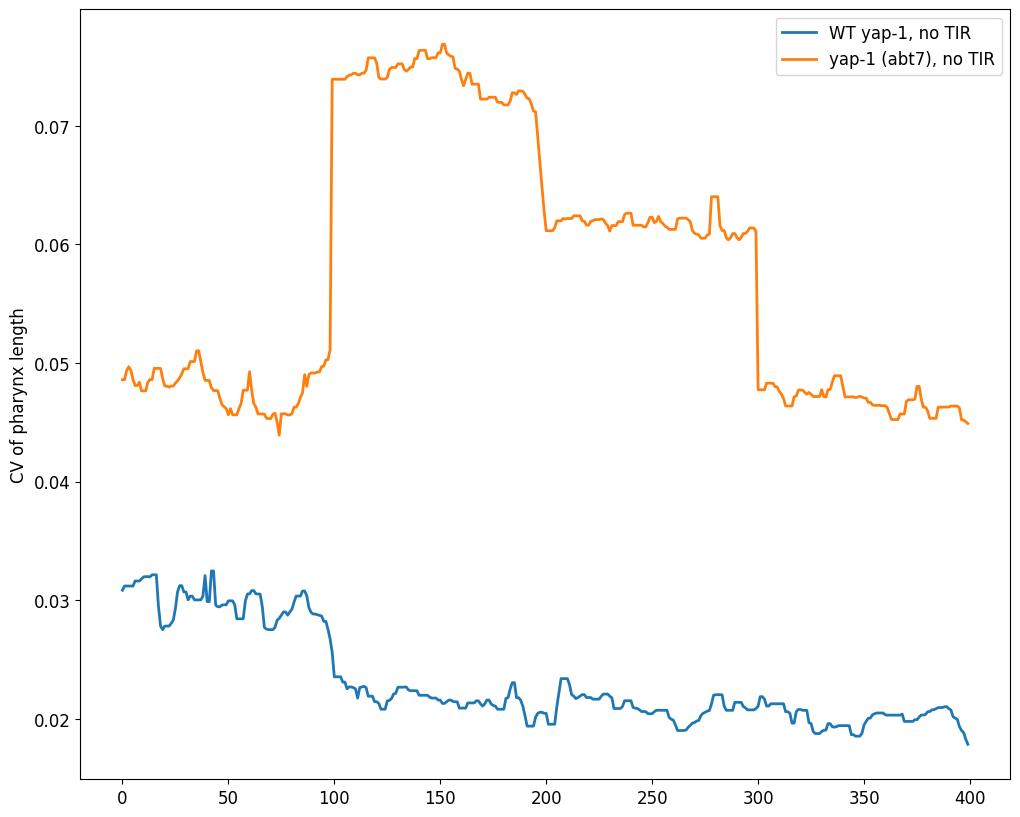

In [87]:
plot_heterogeneity_rescaled_data(conditions_struct, 'pharynx_seg_str_length_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx length') 

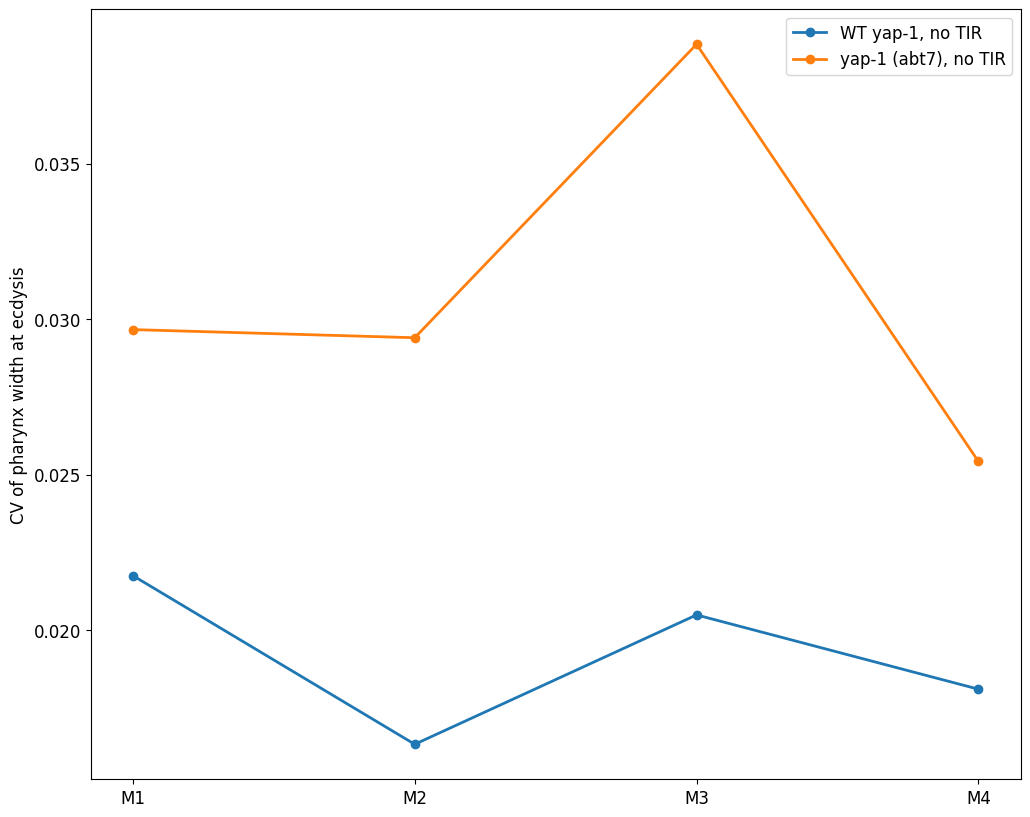

In [88]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'pharynx_seg_str_width_mean_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx width at ecdysis')   

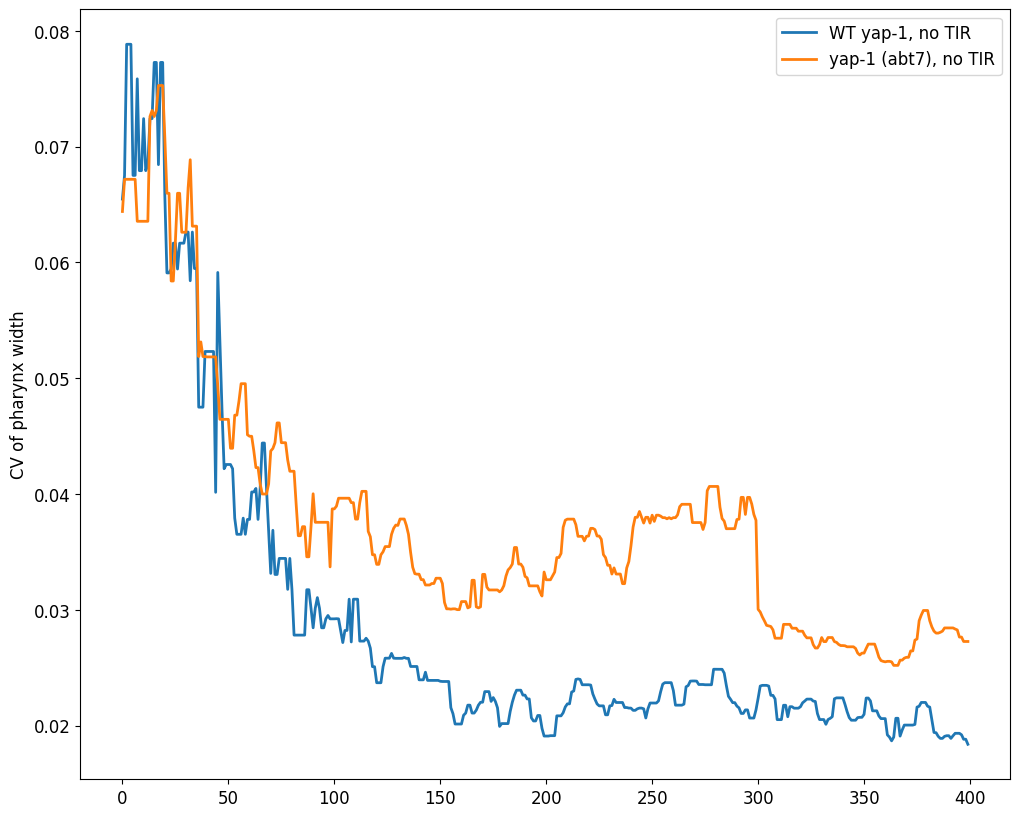

In [89]:
plot_heterogeneity_rescaled_data(conditions_struct, 'pharynx_seg_str_width_mean_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx width') 

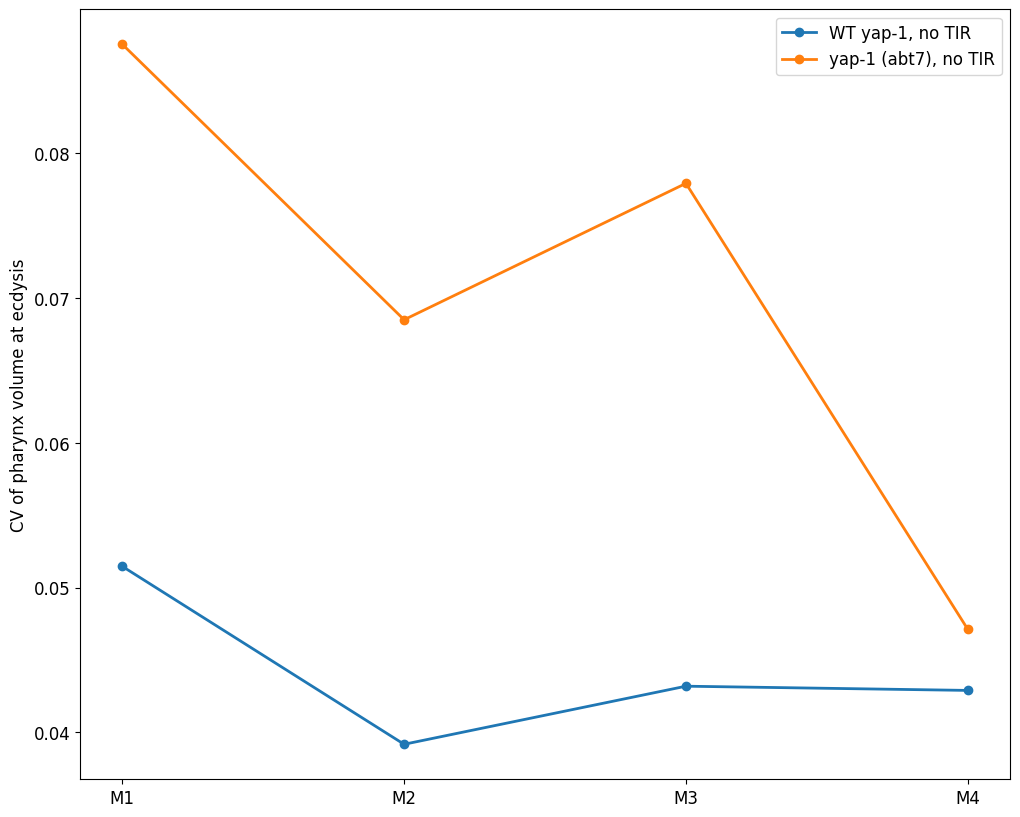

In [90]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'pharynx_seg_str_volume_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx volume at ecdysis')   

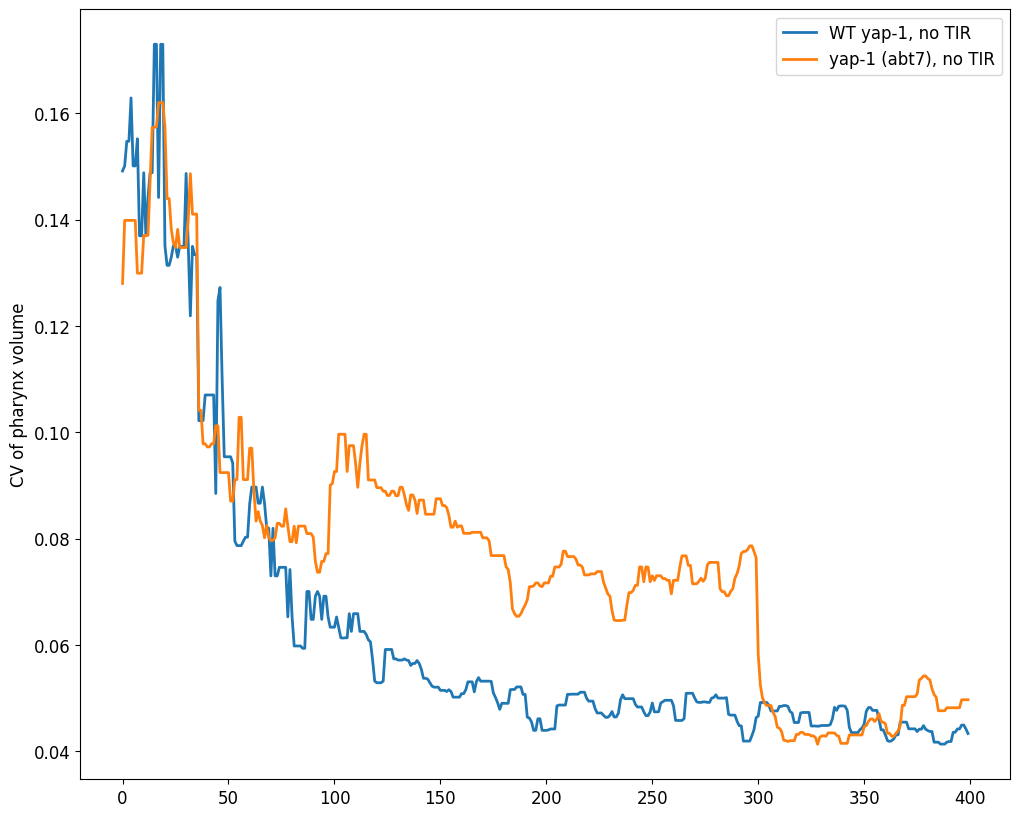

In [91]:
plot_heterogeneity_rescaled_data(conditions_struct, 'pharynx_seg_str_volume_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx volume') 

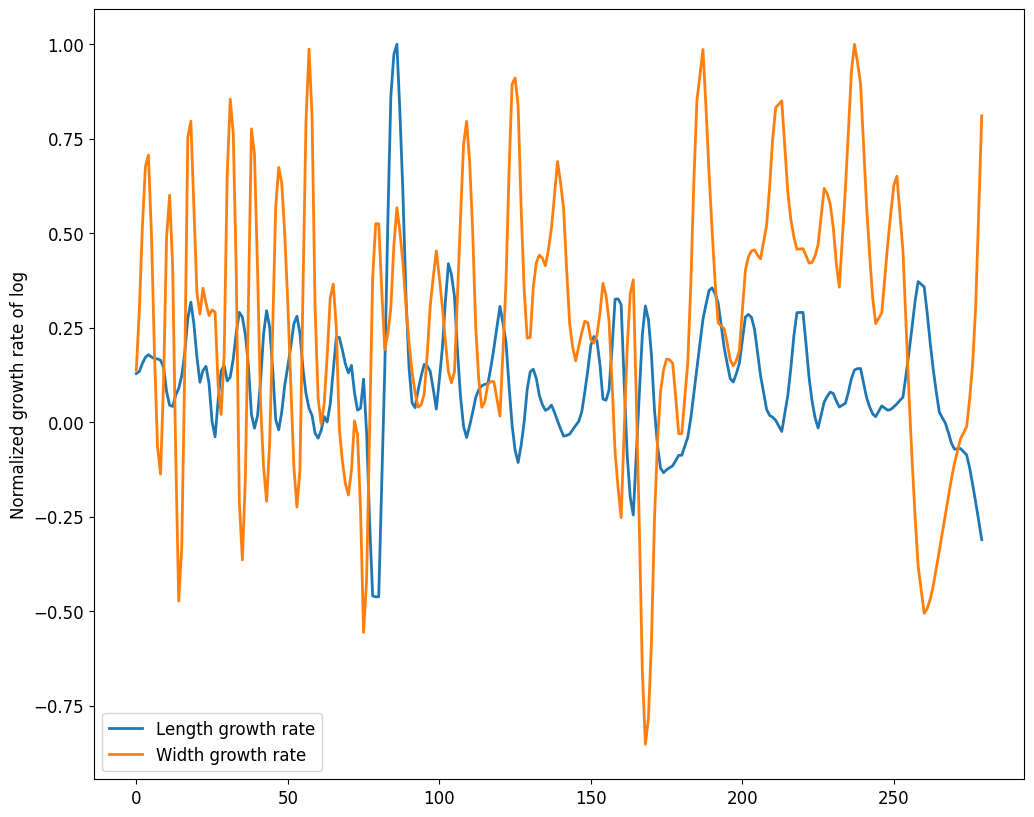

In [92]:
from scipy import signal

idx = 40
s = conditions_struct[0]['body_seg_str_log_length_growth_rate_rescaled'][idx][20:300]
l = conditions_struct[0]['body_seg_str_log_width_mean_growth_rate_rescaled'][idx][20:300]

plt.plot(s/np.max(s))
plt.plot(l/np.max(l))
plt.legend(['Length growth rate', 'Width growth rate'])
plt.ylabel('Normalized growth rate of log')
plt.show()

In [93]:
import numpy
import matplotlib.pyplot as plt
from scipy.signal import correlate
from numpy.linalg import norm
from scipy.stats import spearmanr, pearsonr


def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

def plot_autocorrelation(conditions_struct, series_name, conditions_to_plot, lags,
    colors=None,
    legend=None,
    x_axis_label=None,
    y_axis_label=None,
):
    if colors is None:
        color_palette = sns.color_palette("colorblind", len(conditions_to_plot))
    else:
        color_palette = colors

    for i, condition_id in enumerate(conditions_to_plot):
        condition = conditions_struct[condition_id]
        series = condition[series_name]

        # valid_indices = np.r_[10:70, 110:170, 210:270, 310:370]
        # # set non valid indices to nan
        # series = series[:, valid_indices]

        autocorr = []

        for j in range(series.shape[0]):
            autocorr.append(autocorr1(series[j], lags))
        
        autocorr = np.array(autocorr)

        autocorr_mean = np.nanmean(autocorr, axis=0)
        autocorr_std = np.nanstd(autocorr, axis=0)
        autocorr_ste = autocorr_std / np.sqrt(autocorr.shape[0])

        label = build_legend(condition, legend)

        plt.fill_between(lags, autocorr_mean - 1.96 * autocorr_ste, autocorr_mean + 1.96 * autocorr_ste, alpha=0.5, color=color_palette[i])
        plt.plot(lags, autocorr_mean, label=label, color=color_palette[i])

    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.show()

def plot_cross_correlation(conditions_struct, series_one_name, series_two_name, conditions_to_plot,
    colors=None,
    legend=None,
    x_axis_label=None,
    y_axis_label=None,
    mode='same',
):
    if colors is None:
        color_palette = sns.color_palette("colorblind", len(conditions_to_plot))
    else:
        color_palette = colors

    for i, condition_id in enumerate(conditions_to_plot):
        condition = conditions_struct[condition_id]
        series_one = condition[series_one_name]
        series_two = condition[series_two_name]

        cross_corr = []
        for j in range(series_one.shape[0]):
            norm_series_one = np.linalg.norm(series_one[j])
            norm_series_two = np.linalg.norm(series_two[j])

            normalized_series_one = series_one[j] / norm_series_one
            normalized_series_two = series_two[j] / norm_series_two
            cross_corr.append(signal.correlate(normalized_series_one, normalized_series_two, mode=mode))
            # corr = signal.correlate(series_one[j], series_two[j], mode=mode)
            # cross_corr.append(corr)
            # cross_corr.append(correlate(series_one[j], series_two[j], mode=mode))

        
        cross_corr = np.array(cross_corr)

        cross_corr_mean = np.nanmean(cross_corr, axis=0)
        cross_corr_std = np.nanstd(cross_corr, axis=0)
        cross_corr_ste = cross_corr_std / np.sqrt(cross_corr.shape[0])

        print(cross_corr_mean.shape)
        # Calculate proper x-axis values
        if mode == 'full':
            lags = np.arange(-cross_corr_mean.shape[0] // 2, cross_corr_mean.shape[0] // 2)
        else:  # mode == 'same'
            lags = np.arange(-(cross_corr_mean.shape[0] // 2), cross_corr_mean.shape[0] // 2)

        label = build_legend(condition, legend)

        plt.fill_between(lags,cross_corr_mean - 1.96 * cross_corr_ste, cross_corr_mean + 1.96 * cross_corr_ste, alpha=0.5, color=color_palette[i])
        plt.plot(lags,cross_corr_mean, label=label, color=color_palette[i])

    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.show()

def plot_spearman_correlation(
    conditions_struct,
    series_one_name,
    series_two_name,
    conditions_to_plot,
    colors=None,
    legend=None,
    x_axis_label=None,
    y_axis_label=None,
    log_scale=False,
):
    if colors is None:
        color_palette = sns.color_palette("colorblind", len(conditions_to_plot))
    else:
        color_palette = colors

    for i, condition_id in enumerate(conditions_to_plot):
        condition = conditions_struct[condition_id]
        series_one = condition[series_one_name]
        series_two = condition[series_two_name]

        corr = []
        
        for j in range(series_one.shape[0]):
            # select slice of series_one and series_two, from 0 to 80, 110 to 180, 210 to 280, 310 to 380
            selected_indices = np.r_[10:70, 110:170, 210:270, 310:370]
            # selected_indices = np.r_[80:100, 180:200, 280:300, 380:400]
            selected_series_one = series_one[j][selected_indices]
            selected_series_two = series_two[j][selected_indices]

            # selected_series_one = series_one[j]
            # selected_series_two = series_two[j]

            corr.append(spearmanr(selected_series_one, selected_series_two)[0])
 
        selected_indices = np.r_[20:70, 120:170, 220:270, 320:370]

        series_one_values = np.array(series_one)
        series_two_values = np.array(series_two)

        # remove nans
        nan_indices = np.isnan(series_one_values).any(axis=1) | np.isnan(series_two_values).any(axis=1)
        series_one_values = series_one_values[~nan_indices]
        series_two_values = series_two_values[~nan_indices]

        series_one_values = series_one_values[:, selected_indices]
        series_two_values = series_two_values[:, selected_indices]

        series_one_values = series_one_values.flatten()
        series_two_values = series_two_values.flatten()

        # linear regression
        x = series_one_values
        y = series_two_values
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        results = model.fit()

        print(spearmanr(series_one_values, series_two_values))
        print(pearsonr(series_one_values, series_two_values))
        print(f'R^2: {results.rsquared}')
        # plt.scatter(series_one_values, series_two_values, color=color_palette[i], alpha=0.5)
        # plt.plot(series_one_values, results.params[0] + results.params[1] * series_one_values, color=color_palette[i], label=f"y = {results.params[0]:.2f} + {results.params[1]:.2f}x")
        # plt.show()

        corr = np.array(corr)
        corr_mean = np.nanmean(corr)
        corr_std = np.nanstd(corr)
        corr_ste = corr_std / np.sqrt(corr.shape[0])

        label = build_legend(condition, legend)

        plt.errorbar(i, corr_mean, yerr=1.96 * corr_ste, fmt='o', color=color_palette[i], label=label)

    plt.xticks(range(len(conditions_to_plot)), [conditions_struct[i]['description'] for i in conditions_to_plot], rotation=45)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.show()

(400,)
(400,)


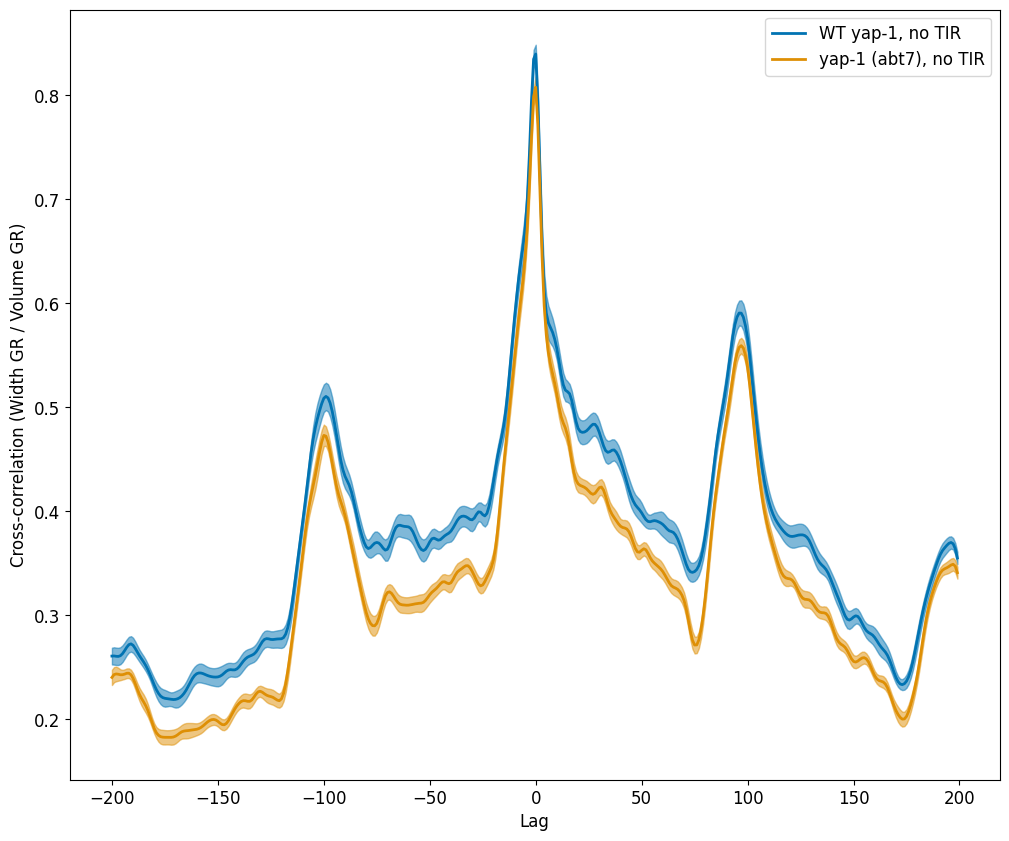

(400,)
(400,)


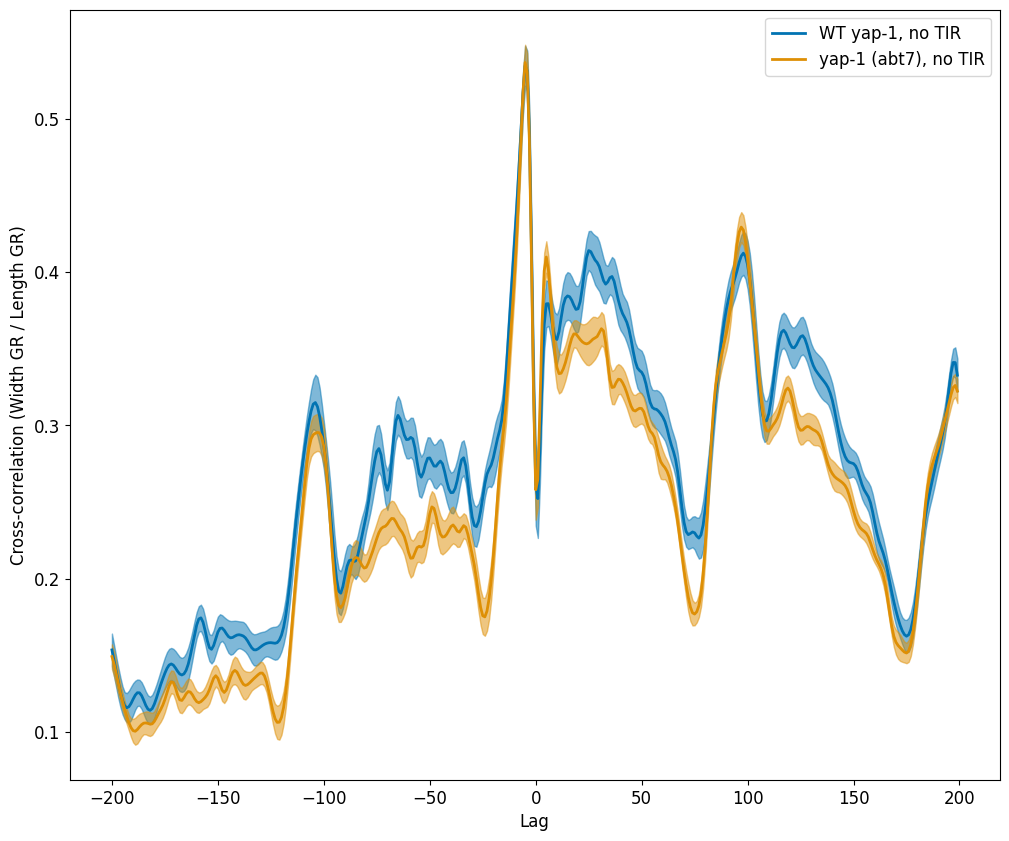

In [94]:
plot_cross_correlation(conditions_struct, 'body_seg_str_log_width_mean_growth_rate_rescaled', 'body_seg_str_log_volume_growth_rate_rescaled', [0, 4], x_axis_label='Lag', y_axis_label='Cross-correlation (Width GR / Volume GR)', legend={'description': ''})
plot_cross_correlation(conditions_struct, 'body_seg_str_log_width_mean_growth_rate_rescaled', 'body_seg_str_log_length_growth_rate_rescaled', [0, 4], x_axis_label='Lag', y_axis_label='Cross-correlation (Width GR / Length GR)', legend={'description': ''})

In [95]:
plot_spearman_correlation(conditions_struct, 'body_seg_str_log_width_mean_growth_rate_rescaled', 'body_seg_str_log_volume_growth_rate_rescaled', [0, 4], x_axis_label='Condition', y_axis_label='Spearman correlation (Width GR / Volume GR)', legend={'description': ''})
plot_spearman_correlation(conditions_struct, 'body_seg_str_log_length_growth_rate_rescaled', 'body_seg_str_log_volume_growth_rate_rescaled', [0, 4], x_axis_label='Condition', y_axis_label='Spearman correlation (Width GR / Volume GR)', legend={'description': ''})
plot_spearman_correlation(conditions_struct, 'body_seg_str_log_width_mean_growth_rate_rescaled', 'body_seg_str_log_length_growth_rate_rescaled', [0, 4], x_axis_label='Condition', y_axis_label='Spearman correlation (Width GR / Length GR)', legend={'description': ''})

NameError: name 'sm' is not defined

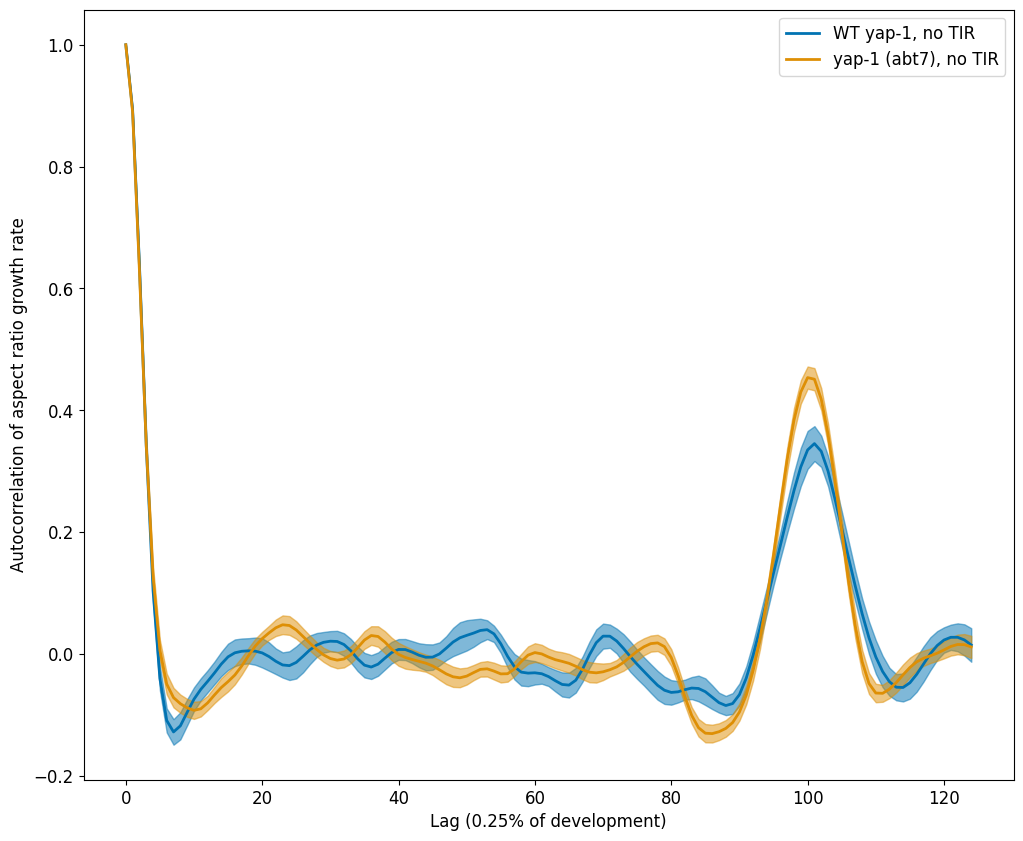

In [165]:
lags = np.arange(0, 125, 1)
plot_autocorrelation(conditions_struct, 'body_seg_str_log_length_growth_rate_rescaled', [0, 4], lags, x_axis_label='Lag (0.25% of development)', y_axis_label='Autocorrelation of aspect ratio growth rate', colors=None, legend={'description': ''})

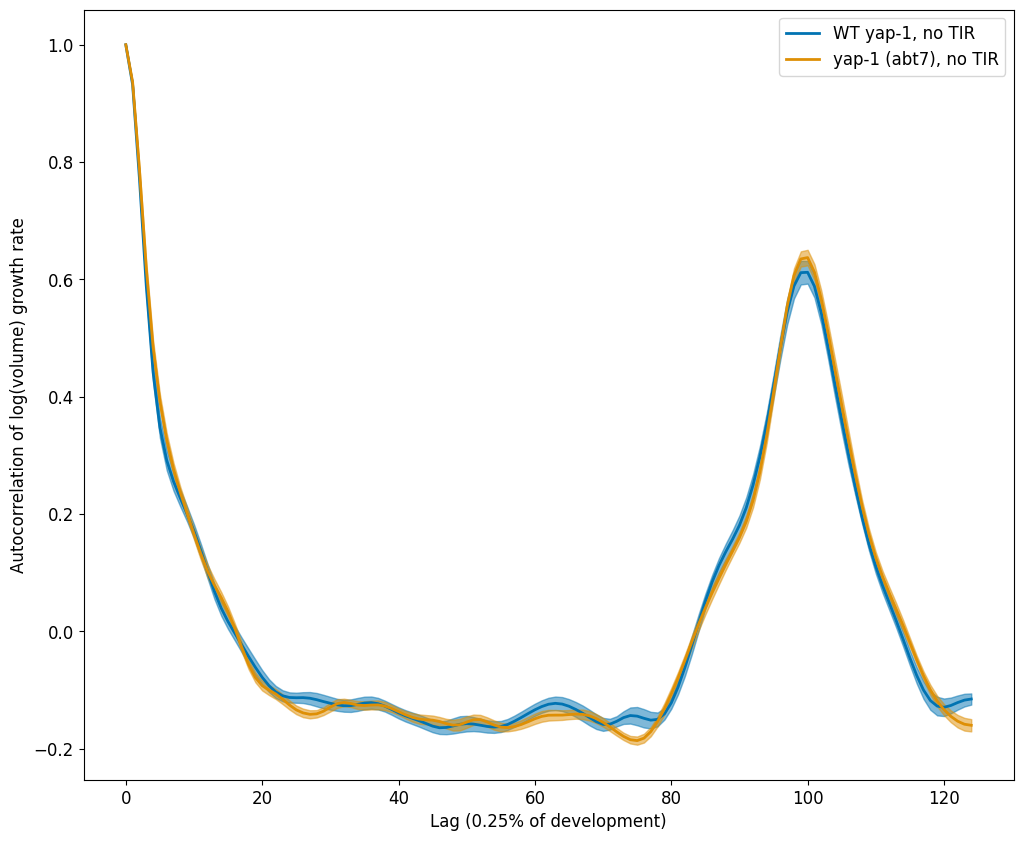

In [166]:
plot_autocorrelation(conditions_struct, 'body_seg_str_log_volume_growth_rate_rescaled', [0, 4], lags, x_axis_label='Lag (0.25% of development)', y_axis_label='Autocorrelation of log(volume) growth rate', colors=None, legend={'description': ''})

In [167]:
# boxplot_at_molt(conditions_struct, 'larval_stage_durations_time_step', [0, 1, 2, 3], log_scale = False, plot_significance=True, legend = {'description': ''}, y_axis_label="Larval stage duration (time step)", titles = ['L1', 'L2', 'L3', 'L4'])

In [169]:
# plot_arrests(conditions_struct, [0, 2, 4, 5], legend = {'description': ''})

In [177]:
# get_most_average_size_at_ecdysis(
#     conditions_struct,
#     'body_seg_str_width_mean_at_ecdysis',
#     ['analysis_sacha/ch2_seg_str'],
#     [4],
#     remove_hatch=False,
#     exclude_arrests=True,
#     dpi=600,
#     nb_per_condition=2,
#     cmap=['pure_red'],
# )

In [178]:
# get_most_average_size_at_ecdysis(
#     conditions_struct,
#     'body_seg_str_volume_at_ecdysis',
#     ['analysis/ch2_raw_str', 'analysis/ch1_raw_str'],
#     [4],
#     remove_hatch=False,
#     exclude_arrests=True,
#     dpi=600,
#     nb_per_condition=2,
#     cmap=['pure_red', 'pure_green'],
# )

In [179]:
# get_most_average_proportions_at_ecdysis(
#     conditions_struct,
#     'body_seg_str_length_at_ecdysis',
#     'body_seg_str_mean_width_at_ecdysis',
#     ['analysis/ch2_raw_str', 'analysis/ch1_raw_str'],
#     [0],
#     remove_hatch=False,
#     exclude_arrests=True,
#     dpi=600,
#     nb_per_condition=2,
#     cmap=['pure_red', 'pure_green'],
# )

In [180]:
# get_most_average_proportions_at_ecdysis(
#     conditions_struct,
#     'body_seg_str_length_at_ecdysis',
#     'body_seg_str_volume_at_ecdysis',
#     ['analysis/ch2_raw_str', 'analysis/ch1_raw_str'],
#     [5],
#     remove_hatch=False,
#     exclude_arrests=True,
#     dpi=600,
#     nb_per_condition=2,
#     cmap=['pure_red', 'pure_green'],
# )